# Instalación e Importación de Librerías

In [1]:
! pip install sqlalchemy==1.4.46
! pip install pandasql==0.7.3

In [2]:
import sys
import os
sys.path.append(".")
import pandas as pd
import pandasql as ps
from datetime import timedelta
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
def thousands_formatter_func(x, pos):
    return f'{int(x / 1e3)}K'
thousand_formatter = FuncFormatter(thousands_formatter_func)
def percentage_formatter_func(x, pos):
    return f'{int(x * 100)}%'
percentage_formatter = FuncFormatter(percentage_formatter_func)


Bad key text.latex.unicode in file /home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fallback_to_cm : True  # When 

# Lectura de archivos

## Lectura Dataset de Bombas

In [3]:
df_bombs = pd.read_csv('data/csv/Dataset_Bombes_2020-23.csv', delimiter=';', encoding='latin-1',  dtype={'T_Diff [s]': 'object'})
df_bombs['dhIni'] = pd.to_datetime(df_bombs['dhIni'], format='%Y-%m-%d %H:%M:%S.%f')
df_bombs['dhFin'] = pd.to_datetime(df_bombs['dhFin'], format='%Y-%m-%d %H:%M:%S.%f')
df_bombs['T_Diff [s]'] = df_bombs['T_Diff [s]'].fillna('0').str.replace('.', '').replace(',', '.').astype(int)
df_bombs['TiempoTeorico [min]'] = df_bombs['TiempoTeorico [min]'].fillna('0').str.replace('.', '').str.replace(',', '.').astype(float)
df_bombs['Orden'] = df_bombs['Orden'].fillna(0).astype(int)
df_bombs['OperIds'] = df_bombs['OperIds'].fillna('')

df_bombs.rename(columns={
    'Orden': 'order',
    'CodMaterial': 'bomb_type',
    'DescMaterial': 'bomb_description',
    'maquina_dsc': 'line',
    'QtyPlan': 'plan_qty',
    'QtyBuenas_Total': 'total_good_qty',
    'QtyMalas_Total': 'total_bad_qty',
    'CantidadBuenas': 'good_qty',
    'CantidadMalas': 'bad_qty',
    'dhIni': 'start_date',
    'dhFin': 'end_date',
    'T_Diff [s]': 'theorical_diff',
    'IncidName': 'incidence_name',
    'Observaciones': 'observations',
    'TiempoTeorico [min]': 'theorical_time',
    'OperariosEnMaq': 'operators_qty',
    'OperIds': 'operators_ids'    
}, inplace=True)

print(df_bombs.shape)
print(df_bombs.dtypes)
df_bombs.head()

/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


(120978, 17)
order                        int64
bomb_type                   object
bomb_description            object
line                        object
plan_qty                   float64
total_good_qty             float64
total_bad_qty              float64
good_qty                   float64
bad_qty                    float64
start_date          datetime64[ns]
end_date            datetime64[ns]
theorical_diff               int64
incidence_name              object
observations                object
theorical_time             float64
operators_qty              float64
operators_ids               object
dtype: object


,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids
0,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:20.250,2020-01-02 05:53:50.063,30,Produccion,NaN,85.00,1.0,5025
1,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:50.063,2020-01-02 05:54:08.010,18,Produccion,NaN,85.00,1.0,5025
2,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:54:08.010,2020-01-02 08:49:39.577,10531,Produccion,NaN,85.00,1.0,5025
3,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 08:49:39.577,2020-01-02 08:59:16.247,577,Produccion,NaN,85.00,1.0,5025
4,5165729,01224-0890,B.CENT.20CV 400/690 1450 S/PR,LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2020-01-02 08:59:48.200,2020-01-02 09:02:40.420,172,Produccion,NaN,85.58,1.0,5025


## Lectura Dataset Defectuosas Interna

In [4]:
df_defective = pd.read_csv('data/csv/Defectuositat_Interna_2020-23.csv', delimiter=';', encoding='latin-1')[:-3]
df_defective['Jornada'] = pd.to_datetime(df_defective['Jornada'], format='%d-%m-%y')
print(df_defective.shape)
print(df_defective.dtypes)
df_defective.head()


(1853, 15)
Jornada       datetime64[ns]
Maq.                  object
OF                   float64
Descripció            object
Item                  object
Component             object
Qty                  float64
T.I.                  object
Motiu                 object
Decisió               object
Units FR             float64
Qty. Fab.            float64
Q.F./Dia             float64
FR                    object
FR/Dia                object
dtype: object


,Jornada,Maq.,OF,Descripció,Item,Component,Qty,T.I.,Motiu,Decisió,Units FR,Qty. Fab.,Q.F./Dia,FR,FR/Dia
0,2023-01-04,LINEA 3,5373418.0,BOMBA VERDON ES 075M,73678,73678-0475,NaN,G,DAÑOS O GOLPES,Destruir,NaN,408.0,NaN,NaN,NaN
1,2023-01-04,LINEA 4,5372007.0,B.A.SENA 33M,25461,25461-0300,NaN,R,ROSCADO EJE MOTOR N/OK,Destruir,NaN,192.0,NaN,NaN,NaN
2,2023-01-04,LINEA 4,5372007.0,B.A.SENA 33M,25461,25461-9601F,NaN,G,FUGAS CIERRE MECÁNICO,Recuperable In Situ,NaN,192.0,NaN,NaN,NaN
3,2023-01-03,LÍNEA KIVU,5371822.0,BOMBA KIVU 4HP 400/6,63043-0890,72A4000075,NaN,G,DAÑOS O GOLPES,Destruir,NaN,6.0,NaN,NaN,NaN
4,2023-01-02,LÍNEA 2,5371351.0,BOMBA V.PLUS SILENT,65562,77C2000064,NaN,G,MONTAJE JUNTA N/OK,Recuperable In Situ,NaN,792.0,NaN,NaN,NaN


## Información Relevante de Bombas

In [5]:
df_exp = df_bombs.operators_ids.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('operators_ids')

In [6]:
print(f"""Resumen información relevante sobre el Dataset de bombas:
--> Cantidad de Órdenes de fabicación: {df_bombs.order.nunique()}
--> Cantidad de distintos materiales: {df_bombs.bomb_type.nunique()}
--> Cantidad de lineas/máquinas: {df_bombs.line.nunique()}
--> Cantidad máxima registrada de operarios en máquinas: {df_bombs.operators_qty.max()}
--> Cantidad de operarios distintos que trabajan en la planta: {df_exp.operators_ids.nunique()}

--> Fecha más antigua de registros: {df_bombs.start_date.min()}
--> Fecha más nueva de registros: {df_bombs.end_date.max()}    
""")

Resumen información relevante sobre el Dataset de bombas:
--> Cantidad de Órdenes de fabicación: 5555
--> Cantidad de distintos materiales: 724
--> Cantidad de lineas/máquinas: 10
--> Cantidad máxima registrada de operarios en máquinas: 8.0
--> Cantidad de operarios distintos que trabajan en la planta: 117

--> Fecha más antigua de registros: 2020-01-02 05:49:27.273000
--> Fecha más nueva de registros: 2023-02-13 13:30:36.823000    



### Revisión de casos Diff cero

In [7]:
print(df_bombs[df_bombs.theorical_diff < 0].order.unique())
df_bombs[df_bombs.theorical_diff < 0].order.nunique()

[5263472 5273225 5275960 5253657 5268390 5288629 5261566 5267248 5257965
 5256172 5265480 5265141 5255357 5274189 5273874 5274188 5281115 5281112
 5287266 5271238 5272862 5280384 5279750 5276295 5278425 5266757 5278420
 5279741 5281111 5282399 5278101 5286927 5286654 5292715 5277735 5282392
 5282397 5292409 5292408 5289828 5278864 5280048 5295482 5280388 5295485
 5293107 5292717 5295268 5279198 5297069 5300944 5288215 5297071 5299075
 5293349 5298783 5302107 5298199 5295267 5305865 5288214 5293108 5304372
 5298785 5293109 5298791 5305922 5298787 5305904 5307933 5310395 5303175
 5306488 5288639 5297584 5295741 5262185 5263883 5281110 5327074 5265473
 5276292 5288137 5282079 5296682 5259363 5313918 5313939 5327336 5327338
 5333201]


91

In [8]:
df_bombs[df_bombs.order == 5263472]

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids
3234,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2021-07-01 09:34:25.470,2021-07-01 09:35:51.207,86,Produccion,NaN,80.0,1.0,5004
3235,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2021-07-01 09:35:51.207,2021-07-01 09:36:15.723,24,Produccion,NaN,80.0,1.0,5004
3236,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2021-07-01 09:36:15.723,2021-07-01 09:14:58.547,-1277,Produccion,NaN,80.0,1.0,5004
3237,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2021-07-01 10:36:50.950,2021-07-01 12:32:11.630,6921,Produccion,NaN,80.0,1.0,5004
3238,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2021-07-01 12:32:11.630,2021-07-01 12:32:22.540,11,Produccion,NaN,80.0,1.0,5004


In [9]:
df_bombs[(df_bombs.theorical_diff < 0) & (df_bombs.good_qty != 0)].order.nunique()

82

Conclusión: eliminar la OF que contengan registros?

## Generación cantidad teórica calculada por registro

Creamos nuestra propias columnas calculadas: <br>
* Cantidad de trabajadores por registro según los ids asociados.
* Diferencia en segundos de tiempo de inicio con tiempo de fin de registro
* Diferencia en minutos de tiempo de inicio con tiempo de fin de registro
* Total de *minutos-hombre* trabajados en el registro ${duración de registo en minutos \times cantidad de operarios en el registro}$

In [10]:
df_bombs['operators_qty_calculated'] = df_bombs.operators_ids.apply(lambda x: len(list(filter(lambda s: s != "", x.split(',')))))
df_bombs['time_diff_seconds_calculated'] = (df_bombs['end_date'] - df_bombs['start_date']) / pd.Timedelta(seconds=1)
df_bombs['time_diff_minutes_calculated'] = (df_bombs['end_date'] - df_bombs['start_date']) / pd.Timedelta(minutes=1)

df_bombs['total_operators_minutes'] = df_bombs['operators_qty_calculated'] * df_bombs['time_diff_minutes_calculated']

df_bombs

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids,operators_qty_calculated,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes
0,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:20.250,2020-01-02 05:53:50.063,30,Produccion,NaN,85.00,1.0,5025,1,29.813,0.496883,0.496883
1,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:50.063,2020-01-02 05:54:08.010,18,Produccion,NaN,85.00,1.0,5025,1,17.947,0.299117,0.299117
2,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:54:08.010,2020-01-02 08:49:39.577,10531,Produccion,NaN,85.00,1.0,5025,1,10531.567,175.526117,175.526117
3,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 08:49:39.577,2020-01-02 08:59:16.247,577,Produccion,NaN,85.00,1.0,5025,1,576.670,9.611167,9.611167
4,5165729,01224-0890,B.CENT.20CV 400/690 1450 S/PR,LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2020-01-02 08:59:48.200,2020-01-02 09:02:40.420,172,Produccion,NaN,85.58,1.0,5025,1,172.220,2.870333,2.870333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120973,5379566,SE2N050M-HS,"B.NEWSE R.I.0,5 CV II R.5425",LINEA 8 IML,30.0,30.0,0.0,1.0,0.0,2023-02-13 07:30:12.033,2023-02-13 07:33:12.597,180,Produccion,NaN,11.00,4.0,"8250,9109,9279,9351,",4,180.564,3.009400,12.037600
120974,5379566,SE2N050M-HS,"B.NEWSE R.I.0,5 CV II R.5425",LINEA 8 IML,30.0,30.0,0.0,1.0,0.0,2023-02-13 07:33:12.597,2023-02-13 07:34:44.927,92,Produccion,NaN,11.00,4.0,"8250,9109,9279,9351,",4,92.330,1.538833,6.155333
120975,5379566,SE2N050M-HS,"B.NEWSE R.I.0,5 CV II R.5425",LINEA 8 IML,30.0,30.0,0.0,1.0,0.0,2023-02-13 07:34:44.927,2023-02-13 07:36:24.893,100,Produccion,NaN,11.00,4.0,"8250,9109,9279,9351,",4,99.966,1.666100,6.664400
120976,5379566,SE2N050M-HS,"B.NEWSE R.I.0,5 CV II R.5425",LINEA 8 IML,30.0,30.0,0.0,0.0,0.0,2023-02-13 07:36:24.893,2023-02-13 07:38:02.443,98,Produccion,NaN,11.00,4.0,"8250,9109,9279,9351,",4,97.550,1.625833,6.503333


## Limpieza

In [11]:
negative_of = df_bombs[df_bombs.time_diff_minutes_calculated < 0].order.unique()
negative_of

array([5263472, 5273225, 5275960, 5253657, 5268390, 5288629, 5261566,
       5267248, 5257965, 5256172, 5265480, 5265141, 5255357, 5274189,
       5273874, 5274188, 5281115, 5281112, 5287266, 5271238, 5272862,
       5280384, 5279750, 5276295, 5278425, 5266757, 5278420, 5279741,
       5281111, 5282399, 5278101, 5286927, 5286654, 5292715, 5277735,
       5282392, 5282397, 5292409, 5292408, 5289828, 5278864, 5280048,
       5295482, 5280388, 5295485, 5293107, 5292717, 5295268, 5279198,
       5297069, 5300944, 5288215, 5297071, 5299075, 5293349, 5298783,
       5302107, 5298199, 5295267, 5305865, 5288214, 5293108, 5304372,
       5298785, 5293109, 5298791, 5305922, 5298787, 5305904, 5307933,
       5310395, 5303175, 5306488, 5288639, 5297584, 5295741, 5262185,
       5263883, 5281110, 5327074, 5265473, 5276292, 5288137, 5282079,
       5296682, 5259363, 5313918, 5313939, 5327336, 5327338, 5333201])

Eliminación de OF con tiempos negativos (confirmar con cliente)

In [12]:
df_bombs = df_bombs[~df_bombs.order.isin(negative_of)]

## Agrupación por Orden de fabricación

In [13]:
df_bombs[df_bombs.order == 5169247]

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids,operators_qty_calculated,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes
8,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:04:45.133,2020-01-03 07:07:13.683,148,Produccion,NaN,80.0,1.0,5025,1,148.550,2.475833,2.475833
9,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:07:13.683,2020-01-03 07:07:47.823,34,Produccion,NaN,80.0,1.0,5025,1,34.140,0.569000,0.569000
10,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:07:47.823,2020-01-03 07:08:02.013,15,Produccion,NaN,80.0,1.0,5025,1,14.190,0.236500,0.236500
11,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:08:02.013,2020-01-03 07:08:21.290,19,Produccion,NaN,80.0,2.0,"5004,5025,",2,19.277,0.321283,0.642567
12,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,4.0,0.0,2020-01-03 07:08:21.290,2020-01-03 10:14:38.720,11177,Produccion,NaN,80.0,2.0,"5004,5025,",2,11177.430,186.290500,372.581000
13,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,2.0,0.0,2020-01-03 10:14:38.720,2020-01-03 11:28:13.407,4415,Produccion,NaN,80.0,2.0,"5004,5025,",2,4414.687,73.578117,147.156233
14,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,3.0,0.0,2020-01-03 11:28:13.407,2020-01-03 13:36:05.923,7672,Produccion,NaN,80.0,2.0,"5004,5025,",2,7672.516,127.875267,255.750533
15,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 13:36:05.923,2020-01-03 13:36:17.010,12,Produccion,NaN,80.0,2.0,"5004,5025,",2,11.087,0.184783,0.369567


In [14]:
df_bombs_grouped = df_bombs.groupby(
        ['order', 'bomb_type', 'line']
    ).agg(
        plan_qty=('plan_qty', 'max'),
        total_good_qty=('total_good_qty', 'max'),
        total_bad_qty=('total_bad_qty', 'max'),
        good_qty=('good_qty', 'sum'),
        bad_qty=('bad_qty', 'sum'),
        start_date=('start_date', 'min'),
        end_date=('end_date', 'max'),
        theorical_diff=('theorical_diff', 'sum'),
        theorical_time=('theorical_time', 'max'),
        time_diff_seconds_calculated=('time_diff_seconds_calculated', 'sum'),
        time_diff_minutes_calculated=('time_diff_minutes_calculated', 'sum'),
        total_operators_minutes=('total_operators_minutes', 'sum'),
        operators_distinct_ids=('operators_ids', lambda x: list(set([i for s in x if isinstance(s, str) for i in s.split(',') if i]))),
        registers_qty=('start_date', 'count'),
        
    ).reset_index()
df_bombs_grouped['operators_distinct_qty'] = df_bombs_grouped.operators_distinct_ids.apply(lambda x: len(x))
df_bombs_grouped['theorical_qty'] = df_bombs_grouped.total_operators_minutes/df_bombs_grouped.theorical_time
df_bombs_grouped['theorical_qty_round'] = df_bombs_grouped.theorical_qty.round(0)
df_bombs_grouped['performance'] = df_bombs_grouped.good_qty/df_bombs_grouped.theorical_qty
df_bombs_grouped['performance_round'] = df_bombs_grouped.good_qty/df_bombs_grouped.theorical_qty_round
df_bombs_grouped

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
0,274185,HPS050M,LÍNEA 2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"[8860, 8177, 8250, 9105, 8164, 8830, 8615, 918...",10,11,44.226687,44.0,0.000000,0.000000
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"[8860, 8822, 5020, 8866, 9120]",4,5,0.353680,0.0,0.000000,NaN
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"[9436, 9142, 5033]",8,3,34.185148,34.0,0.000000,0.000000
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,1391,8.21,1390.997,23.183283,46.366567,"[5015, 5036]",2,2,5.647572,6.0,1.416538,1.333333
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,[5025],8,1,2.458296,2.0,0.813572,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,5382620,M00874TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:48:58.883,2023-02-02 16:49:22.223,24,8.41,23.340,0.389000,0.389000,[1007],3,1,0.046254,0.0,21.619537,inf
5462,5382621,M00875TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:47:14.330,2023-02-02 16:48:20.677,66,8.41,66.347,1.105783,1.105783,[1007],3,1,0.131484,0.0,7.605468,inf
5463,5382622,M00876TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:49:43.490,2023-02-02 16:50:07.023,24,8.41,23.533,0.392217,0.392217,[1007],3,1,0.046637,0.0,21.442230,inf
5464,5382623,M00877TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:51:05.457,2023-02-02 16:51:35.050,30,8.41,29.593,0.493217,0.493217,[1007],3,1,0.058646,0.0,17.051330,inf


In [15]:
df_of = df_bombs_grouped.copy()

In [16]:
df_of[(df_of['end_date'] - df_of['start_date']) / pd.Timedelta(minutes=60) > 120]

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
0,274185,HPS050M,LÍNEA 2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"[8860, 8177, 8250, 9105, 8164, 8830, 8615, 918...",10,11,44.226687,44.0,0.000000,0.000000
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"[8860, 8822, 5020, 8866, 9120]",4,5,0.353680,0.0,0.000000,NaN
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"[9436, 9142, 5033]",8,3,34.185148,34.0,0.000000,0.000000
8,5159134,65567,LÍNEA 2,270.0,270.0,0.0,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,"[8615, 504, 8230, 918]",25,4,382.215130,382.0,0.706408,0.706806
15,5162031,8005,LINEA 6,90.0,90.0,0.0,90.0,0.0,2020-01-03 12:18:23.493,2020-01-09 10:04:07.950,49428,21.54,49427.394,823.789900,2393.615867,"[7028, 8945, 287]",28,3,111.124228,111.0,0.809904,0.810811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5321,5374958,25463,LINEA 4,510.0,510.0,0.0,510.0,0.0,2023-01-13 11:34:28.843,2023-01-19 08:44:06.417,110186,7.10,110187.119,1836.451983,3803.301117,"[8164, 9351, 9142, 9279, 8833]",52,5,535.676214,536.0,0.952068,0.951493
5322,5374960,25463,LINEA 4,270.0,270.0,0.0,271.0,0.0,2023-02-03 05:34:35.807,2023-02-08 11:48:54.497,112247,7.10,112247.123,1870.785383,1870.785383,[8164],23,1,263.490899,263.0,1.028499,1.030418
5324,5374962,25465,LINEA 4,540.0,540.0,0.0,541.0,0.0,2023-01-19 09:12:15.957,2023-01-26 09:55:57.447,153218,7.10,153217.390,2553.623167,3808.792600,"[8164, 8615, 654, 918, 8833]",60,5,536.449662,536.0,1.008482,1.009328
5336,5375555,8003,LINEA 6,90.0,90.0,0.0,90.0,0.0,2023-01-25 13:32:57.343,2023-01-31 11:54:36.673,110822,21.54,110822.267,1847.037783,1847.037783,[9142],26,1,85.749201,86.0,1.049572,1.046512


In [17]:
oper_list = []
for  x in df_of[df_of.operators_distinct_qty == 1].operators_distinct_ids:
    operador = x[0]
    if operador not in oper_list:
        oper_list.append(operador)
        
oper_list
len(oper_list)

25

Más información relevante:

In [18]:
print(f'''
    | Cantidad total órdenes de fabricación: {df_of.shape[0]}
    | Cantidad de órdenes de fabricación con diferencia en cantidad buenas reportadas versus la suma de sus registros: {df_of[df_of.total_good_qty != df_of.good_qty].shape[0]}
        -> Casos CantidadBuenas > QtyBuenas_total : {df_of[df_of.total_good_qty < df_of.good_qty].shape[0]}  
        -> Casos CantidadBuenas < QtyBuenas_total : {df_of[df_of.total_good_qty > df_of.good_qty].shape[0]} 
    
    | Cantidad máxima de operadores trabajando en una misma OF: {df_of.operators_distinct_qty.max()}
    
    | Cantidad de órdenes con Qtyplan distintos a cantidad teórica calculada: {df_of[df_of.plan_qty != df_of.theorical_qty_round].shape[0]}
    
    | Duración máxima (minutos) de un registro: {df_bombs.time_diff_minutes_calculated.max()}
''')


    | Cantidad total órdenes de fabricación: 5466
    | Cantidad de órdenes de fabricación con diferencia en cantidad buenas reportadas versus la suma de sus registros: 325
        -> Casos CantidadBuenas > QtyBuenas_total : 45  
        -> Casos CantidadBuenas < QtyBuenas_total : 280 
    
    | Cantidad máxima de operadores trabajando en una misma OF: 12
    
    | Cantidad de órdenes con Qtyplan distintos a cantidad teórica calculada: 4987
    
    | Duración máxima (minutos) de un registro: 937.5479



Revisión de cantidad de OF operadas por línea:

In [19]:
df_of.groupby('line').size().reset_index(name='count').sort_values(by='count', ascending=False)

,line,count
6,LÍNEA 2,1366
4,LINEA 8 IML,998
0,LINEA 3,686
1,LINEA 4,671
2,LINEA 6,581
5,LÍNEA 1,532
7,LÍNEA KIVU,301
3,LINEA 7,181
8,PREFILTRO L-1,87
9,PREFILTRO L-6,63


Revisión de cantidad de tipos de bombas operadas por máquina:

In [20]:
df_bombs.bomb_type.nunique()

724

In [21]:
df_of.groupby(['line', 'bomb_type']).size().reset_index().groupby(['line']).size().reset_index(name='count').sort_values(by='count', ascending=False)

,line,count
4,LINEA 8 IML,335
0,LINEA 3,131
6,LÍNEA 2,82
1,LINEA 4,59
5,LÍNEA 1,55
2,LINEA 6,42
7,LÍNEA KIVU,32
3,LINEA 7,24
8,PREFILTRO L-1,10
9,PREFILTRO L-6,4


Revisión de líneas por bomba:

In [22]:
df_grouped = df_of.groupby(['line', 'bomb_type']).size().reset_index().groupby(['bomb_type']).size().reset_index(name='lines_count').sort_values(by='lines_count', ascending=False)
print(df_grouped[df_grouped.lines_count >= 2].shape[0])
df_grouped[df_grouped.lines_count >= 2]

49


,bomb_type,lines_count
505,PT001,3
247,65569H,2
235,65566,2
510,SA033MIML000,2
239,65566H,2
240,65566ME,2
241,65567,2
243,65567H,2
244,65567ME,2
245,65569,2


Revisión de tipos de bomba por orden de fabricación

In [23]:
df_grouped = df_of.groupby(['order', 'bomb_type']).size().reset_index().groupby(['order']).size().reset_index(name='count').sort_values(by='count', ascending=False)
df_grouped[df_grouped['count'] > 1]

,order,count


>Nota: órdenes de fabricación hace alusión a un único tipo de bomba

# EDA

## Exploración de Dataset de bombas

### Exploración de valores por columnas

In [24]:
df_bombs.head()

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids,operators_qty_calculated,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes
0,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:20.250,2020-01-02 05:53:50.063,30,Produccion,NaN,85.00,1.0,5025,1,29.813,0.496883,0.496883
1,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:50.063,2020-01-02 05:54:08.010,18,Produccion,NaN,85.00,1.0,5025,1,17.947,0.299117,0.299117
2,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:54:08.010,2020-01-02 08:49:39.577,10531,Produccion,NaN,85.00,1.0,5025,1,10531.567,175.526117,175.526117
3,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 08:49:39.577,2020-01-02 08:59:16.247,577,Produccion,NaN,85.00,1.0,5025,1,576.670,9.611167,9.611167
4,5165729,01224-0890,B.CENT.20CV 400/690 1450 S/PR,LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2020-01-02 08:59:48.200,2020-01-02 09:02:40.420,172,Produccion,NaN,85.58,1.0,5025,1,172.220,2.870333,2.870333


Revisión de cantidad de valores distintos por columna

In [25]:
results = []
for col in df_bombs.columns:
    results.append([col, len(df_bombs[col].unique())])
pd.DataFrame(results, columns=['Column', 'Distinct Values'])

,Column,Distinct Values
0,order,5464
1,bomb_type,725
2,bomb_description,745
3,line,11
4,plan_qty,257
5,total_good_qty,319
6,total_bad_qty,2
7,good_qty,152
8,bad_qty,2
9,start_date,117589


Revisión de tipos de incidencias registrados:

In [26]:
df_bombs.groupby(['incidence_name']).size().reset_index(name='count')

,incidence_name,count
0,Falta de Material,289
1,Preparacion,59
2,Problema Mantenimiento,3305
3,Produccion,114197


> Nota: existen registros que tiene incidencia nula. Por lo observado esto se debe a que la observación de ciertos registros abarca más de una celda en el excel. A validar con el cliente qué hacer con estos casos

### Exploración de desempeño general por máquina

In [27]:
df_bombs.groupby(['line']).agg(good_qty=('good_qty', 'sum'), bad_qty=('bad_qty', 'sum'))


,good_qty,bad_qty
line,,
LINEA 3,67877.0,0.0
LINEA 4,110861.0,0.0
LINEA 6,24104.0,0.0
LINEA 7,43430.0,0.0
LINEA 8 IML,46218.0,0.0
LÍNEA 1,3918.0,0.0
LÍNEA 2,255442.0,0.0
LÍNEA KIVU,1862.0,0.0
PREFILTRO L-1,1138.0,0.0


In [28]:
df_bombs_grouped = df_of.groupby(['line']).agg(theorical_qty=('theorical_qty', 'sum'), theorical_qty_round=('theorical_qty_round', 'sum'), good_qty=('good_qty', 'sum'))
df_bombs_grouped['success_percentage'] = (df_bombs_grouped.good_qty / df_bombs_grouped.theorical_qty *100).round(2) 
df_bombs_grouped['success_percentage_round'] = (df_bombs_grouped.good_qty / df_bombs_grouped.theorical_qty_round *100).round(2)
df_bombs_grouped

,theorical_qty,theorical_qty_round,good_qty,success_percentage,success_percentage_round
line,,,,,
LINEA 3,84608.989077,84630.0,67877.0,80.22,80.20
LINEA 4,117147.735803,117143.0,110861.0,94.63,94.64
LINEA 6,25467.941915,25471.0,24104.0,94.64,94.63
LINEA 7,49048.488617,49045.0,43430.0,88.55,88.55
LINEA 8 IML,67466.196526,67476.0,46218.0,68.51,68.50
LÍNEA 1,4269.411236,4260.0,3918.0,91.77,91.97
LÍNEA 2,280375.853418,280373.0,255442.0,91.11,91.11
LÍNEA KIVU,2274.718984,2282.0,1862.0,81.86,81.60
PREFILTRO L-1,1654.486596,1658.0,1138.0,68.78,68.64


### Gráficas de interés


#### ¿Cuál es el rango de fechas en el dataset? ¿Existen periodos de inactividad notables en la producción?

In [29]:
def plot_daily_production(df, title):
    data_daily = df.resample('D', on='start_date').sum()
    plt.figure(figsize=(10, 5))
    plt.plot(data_daily.index, data_daily['good_qty'])
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de producción')
    plt.title(title)
    plt.show()
    

>Gráfico 1: Series temporales de producción a lo largo del tiempo (por día)

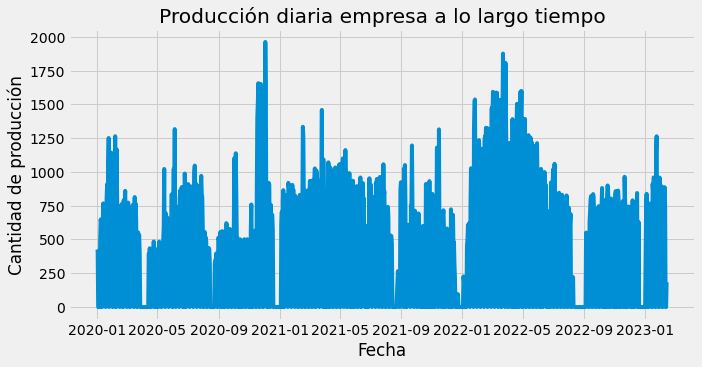

In [30]:
plot_daily_production(df_bombs, 'Producción diaria empresa a lo largo tiempo')

>Gráfico 2: Series temporales de producción a lo largo del tiempo (por día) para el año 2020

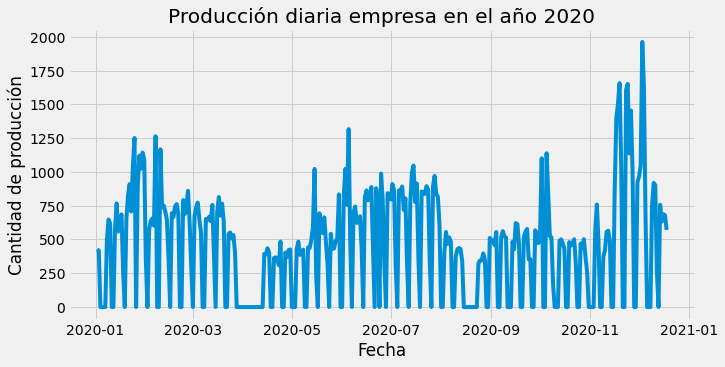

In [31]:
year = 2020
plot_daily_production(df_bombs[df_bombs.start_date.dt.year == year], f'Producción diaria empresa en el año {year}')

>Gráfico 3: Comparación producción mensual por año

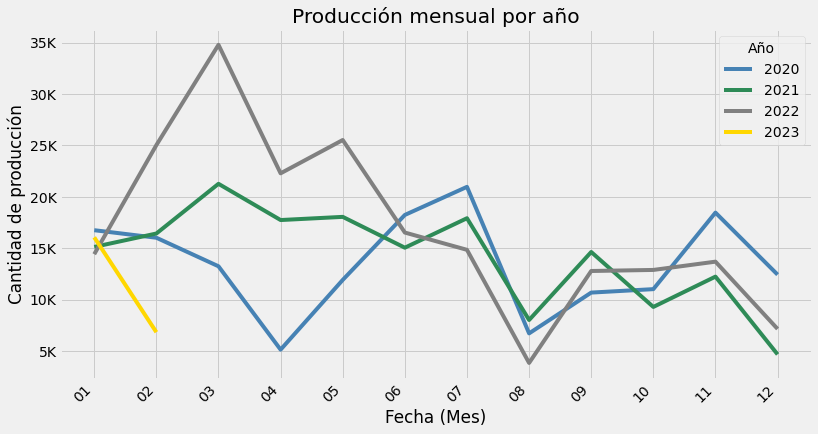

In [32]:
data = df_bombs.copy()
# Crear una columna solo con el mes y el día
data['month'] = data.end_date.dt.strftime('%m')

# Agrupar por año, mes y día, y calcular la cantidad de producción diaria
data_daily = data.groupby([data.end_date.dt.year, 'month'])['good_qty'].sum().reset_index()
data_daily.columns = ['year', 'month', 'good_qty']

# Función para formatear las etiquetas del eje y
def thousands_formatter(x, pos):
    return f'{int(x / 1e3)}K'

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Obtener los años únicos
unique_years = data_daily['year'].unique()

# Colors
color_pal = sns.color_palette(['steelblue', 'seagreen', 'gray', 'gold', 'magenta', 'yellow'])

for i, year in enumerate(unique_years):
    yearly_data = data_daily[data_daily['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['good_qty'], label=str(int(year)), color=color_pal[i])

plt.xlabel('Fecha (Mes)')
plt.ylabel('Cantidad de producción')
plt.title('Producción mensual por año')

# Aplicar el formateador al eje y
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title='Año')
plt.xticks(rotation=45, ha='right')
plt.show()

#### ¿Cuáles son los tipos de bombas más y menos producidos?

In [33]:
df_bombs.bomb_type.nunique()

724

Dada la cantidad de tipos de bombas, revisaremos las 20 más producidos y las 20 menos producidos

>Gráfico 4: Cantidad producida de las 20 tipos de bombas más demandados

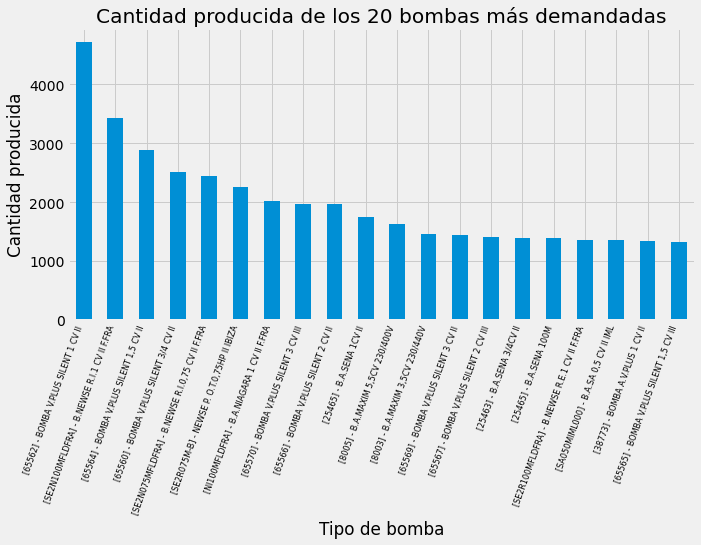

In [34]:
material_counts = df_bombs.groupby(['bomb_type', 'bomb_description'])['good_qty'].size().reset_index(name='count').sort_values(by='count', ascending=False)
material_counts['code_description'] = '[' + material_counts['bomb_type'].astype(str) + '] - ' + material_counts['bomb_description']
material_counts[0:20].plot(kind='bar', x='code_description', figsize=(10, 5))
plt.xlabel('Tipo de bomba')
plt.ylabel('Cantidad producida')
plt.title('Cantidad producida de los 20 bombas más demandadas')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(False)
plt.show()

>Gráfico 4: Cantidad producida de los 20 materiales menos demandados

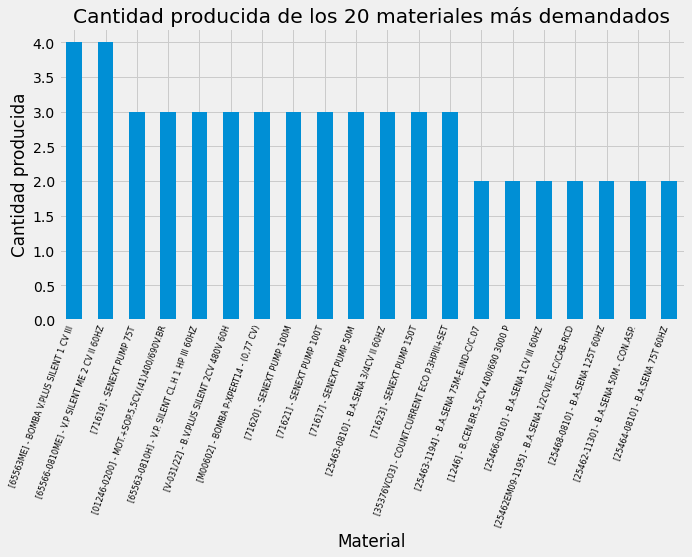

In [35]:
material_counts[-20:].plot(kind='bar', x='code_description', figsize=(10, 5))
plt.xlabel('Material')
plt.ylabel('Cantidad producida')
plt.title('Cantidad producida de los 20 materiales más demandados')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(False)
plt.show()

#### ¿Cuáles son los materiales más defectuosos?

Dada la cantidad de materiales, revisaremos los 20 más defectuosos y los 20 menos defectuosos
>Se revisa en la data que entre todos los registros, no hay ninguno que tenga QtyMalas_Total y CantidadMalas

#### ¿Cuáles son las máquinas que más y menos producen?

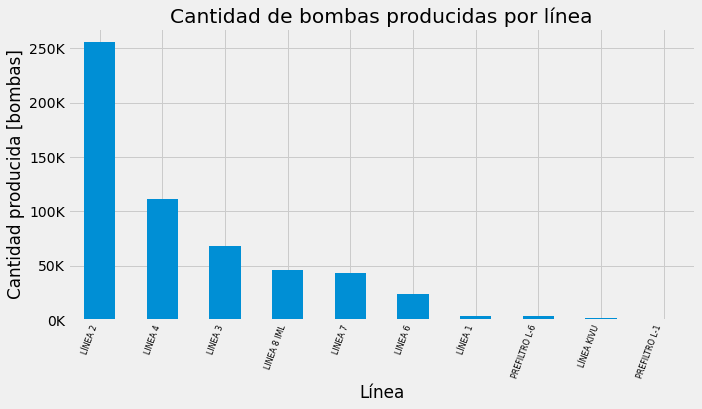

In [36]:
bomb_counts = df_bombs.groupby(['line'])['good_qty'].sum().reset_index(name='count').sort_values(by='count', ascending=False)
bomb_counts.plot(kind='bar', x='line', figsize=(10, 5))
plt.xlabel('Línea')
plt.ylabel('Cantidad producida [bombas]')
plt.title('Cantidad de bombas producidas por línea')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().yaxis.set_major_formatter(thousand_formatter)
plt.gca().legend().set_visible(False)
plt.show()

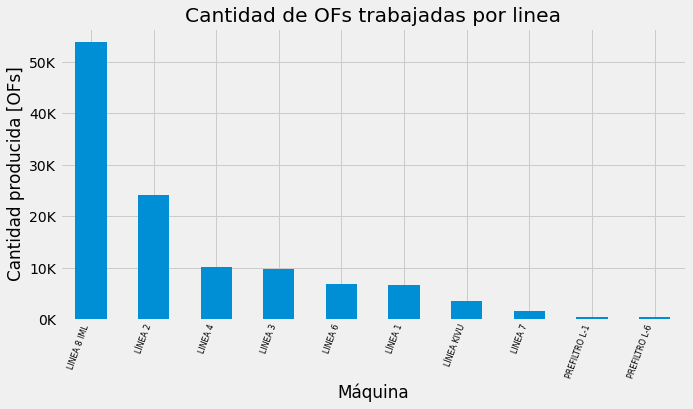

In [37]:
bomb_counts = df_bombs.groupby(['line'])['order'].size().reset_index(name='count').sort_values(by='count', ascending=False)
bomb_counts.plot(kind='bar', x='line', figsize=(10, 5))
plt.xlabel('Máquina')
plt.ylabel('Cantidad producida [OFs]')
plt.title('Cantidad de OFs trabajadas por linea')

plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().yaxis.set_major_formatter(thousand_formatter)
plt.gca().legend().set_visible(False)
plt.show()

#### ¿Cuáles son los tiempos de producción de las lineas?

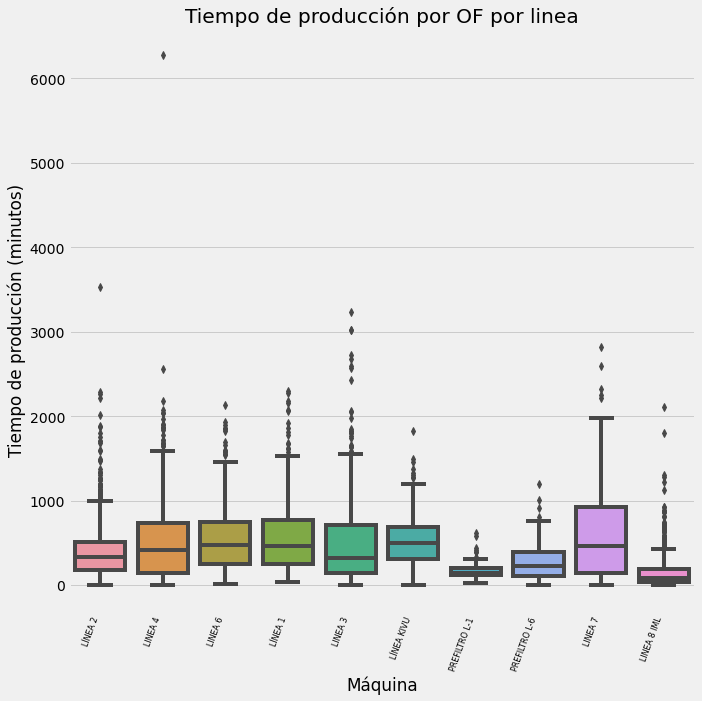

In [38]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_of, x='line', y='time_diff_minutes_calculated')
plt.xlabel('Máquina')
plt.ylabel('Tiempo de producción (minutos)')
plt.title('Tiempo de producción por OF por linea')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.show()

In [39]:
df_of[df_of.theorical_qty > 4000]

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
241,5175256,20578VP176/2,LINEA 7,3.0,3.0,0.0,3000.0,0.0,2020-01-25 06:02:25.730,2020-02-01 11:38:34.697,169110,1.1,169108.206,2818.4701,4599.75625,"[643, 654, 5004, 5030, 642, 8733]",43,6,4181.596591,4182.0,0.717429,0.71736


In [40]:
df_bombs[df_bombs.order == 5313435]

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids,operators_qty_calculated,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes
62131,5313435,M00603,"BOMBA P-XPERT16 - (1,03 CV)",LINEA 7,11.0,11.0,0.0,0.0,0.0,2022-06-01 11:11:42.270,2022-06-01 11:12:15.140,33,Produccion,NaN,2.95,2.0,"654,9317,",2,32.870,0.547833,1.095667
62132,5313435,M00603,"BOMBA P-XPERT16 - (1,03 CV)",LINEA 7,11.0,11.0,0.0,0.0,0.0,2022-06-01 11:12:15.140,2022-06-01 11:13:01.950,46,Produccion,NaN,2.95,2.0,"654,9317,",2,46.810,0.780167,1.560333
62133,5313435,M00603,"BOMBA P-XPERT16 - (1,03 CV)",LINEA 7,11.0,11.0,0.0,11.0,0.0,2022-06-01 11:13:01.950,2022-06-01 11:13:19.327,18,Produccion,NaN,2.95,2.0,"654,9317,",2,17.377,0.289617,0.579233


In [41]:
df_of[df_of.performance > 2].shape

(54, 22)

In [42]:
df_of[df_of.time_diff_minutes_calculated > 24*60].shape

(142, 22)

#### ¿Cuáles es la relación entre la cantidad teórica y la cantidad real?

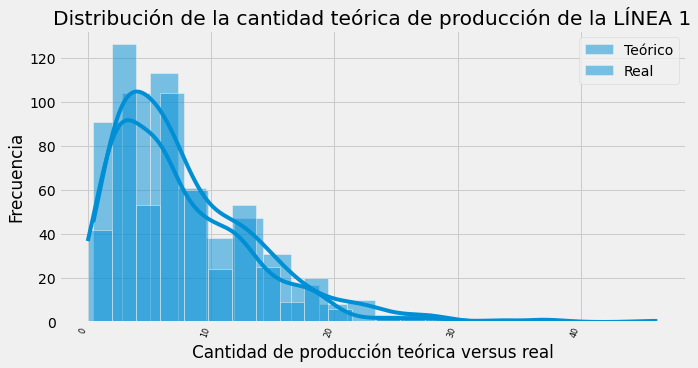

In [43]:
data = df_of[df_of.line == 'LÍNEA 1'].sort_values(by='theorical_qty')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='theorical_qty', bins=20, kde=True, label='Teórico')
sns.histplot(data=data, x='good_qty', bins=20, kde=True, label='Real')
plt.xlabel('Cantidad de producción teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LÍNEA 1')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()

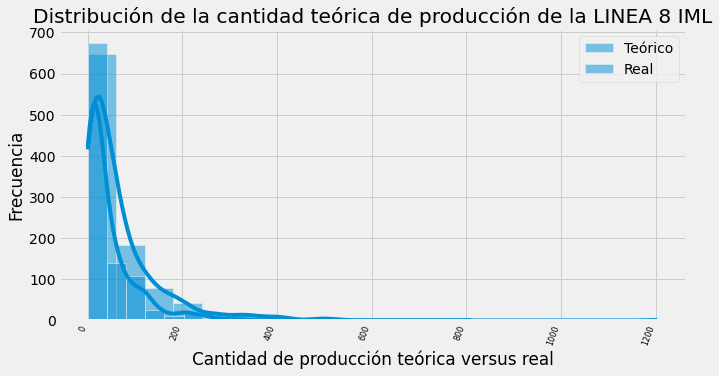

In [44]:
data = df_of[df_of.line == 'LINEA 8 IML'].sort_values(by='theorical_qty')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='theorical_qty', bins=20, kde=True, label='Teórico')
sns.histplot(data=data, x='good_qty', bins=20, kde=True, label='Real')
plt.xlabel('Cantidad de producción teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LINEA 8 IML')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()

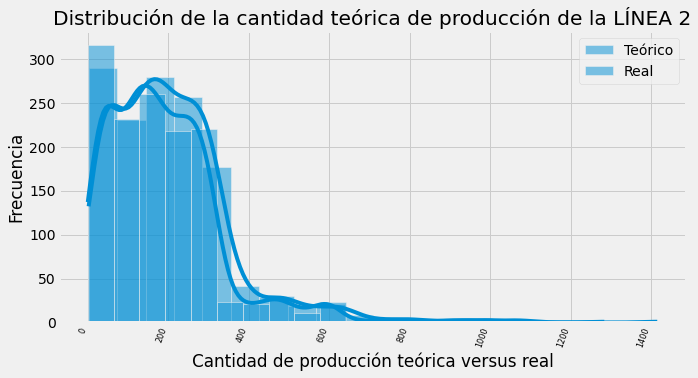

In [45]:
data = df_of[df_of.line == 'LÍNEA 2'].sort_values(by='theorical_qty')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='theorical_qty', bins=20, kde=True, label='Teórico')
sns.histplot(data=data, x='good_qty', bins=20, kde=True, label='Real')
plt.xlabel('Cantidad de producción teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LÍNEA 2')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()

#### Performance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


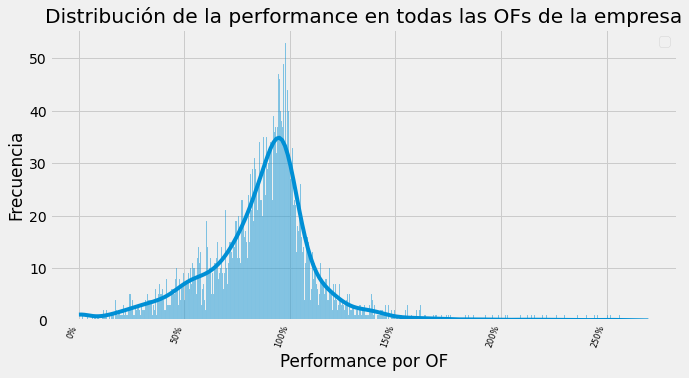

In [46]:
data = df_of.sort_values(by='performance')
data = df_of[df_of.performance < 3].sort_values(by='performance')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', bins=1000, kde=True)
plt.xlabel('Performance por OF')
plt.ylabel('Frecuencia')
plt.title('Distribución de la performance en todas las OFs de la empresa')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


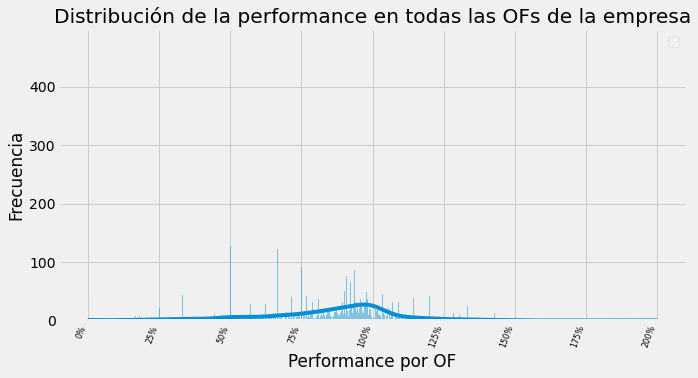

In [47]:
data = df_of.sort_values(by='performance')
data = df_of[(df_of.performance < 1.5)].sort_values(by='performance')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance_round', bins=1000, kde=True)
plt.xlabel('Performance por OF')
plt.ylabel('Frecuencia')
plt.title('Distribución de la performance en todas las OFs de la empresa')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


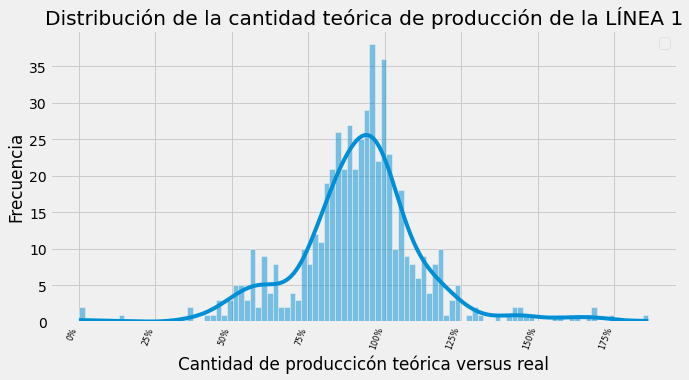

In [48]:
data = df_of[df_of.line == 'LÍNEA 1'].sort_values(by='performance')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', bins=100, kde=True)
plt.xlabel('Cantidad de produccicón teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LÍNEA 1')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


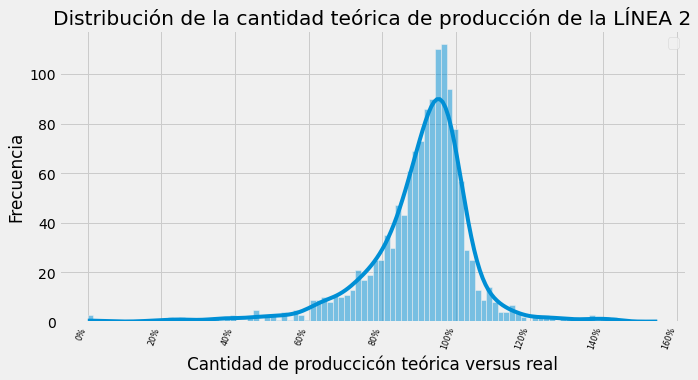

In [49]:
data = df_of[df_of.line == 'LÍNEA 2'].sort_values(by='performance')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', bins=100, kde=True)
plt.xlabel('Cantidad de produccicón teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LÍNEA 2')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.show()

#### Análisis corte de performance según respuesta de Sergi

In [50]:
df_of.head(5)

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
0,274185,HPS050M,LÍNEA 2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"[8860, 8177, 8250, 9105, 8164, 8830, 8615, 918...",10,11,44.226687,44.0,0.000000,0.000000
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"[8860, 8822, 5020, 8866, 9120]",4,5,0.353680,0.0,0.000000,NaN
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"[9436, 9142, 5033]",8,3,34.185148,34.0,0.000000,0.000000
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,1391,8.21,1390.997,23.183283,46.366567,"[5015, 5036]",2,2,5.647572,6.0,1.416538,1.333333
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,[5025],8,1,2.458296,2.0,0.813572,1.000000


Según comentó Sergi, los tiempos teóricos estan bastante ajustados lo que implica que realmente obtener performances mayores al 100% es muy complicado. Vamos analizar cuantas OFs hay entre el 100 y 120% para tomar una decisión

In [51]:
df_of[df_of.performance >= 1].shape

(1301, 22)

In [52]:
df_of[df_of.performance >= 1.2].shape

(365, 22)

Podemos observar como por encima del 100% hay 1301 OFs. Sin embargo, por encima del 120% hay 365 OFs... 
En este caso si pusieramos el corte en el 120% estariamos perdiendo:

In [53]:
df_of.shape

(5466, 22)

In [54]:

print(f'La perdida de OFs con el corte en un 120% és de: {(len(df_of[df_of.performance > 1.2]))/(len(df_of))*100}%')

La perdida de OFs con el corte en un 120% és de: 6.6776436150750085%


In [55]:
print(f'La perdida de OFs con el corte en un 100% és de: {(len(df_of[df_of.performance >= 1]))/(len(df_of))*100}%')

La perdida de OFs con el corte en un 100% és de: 23.80168313208928%


Como podemos observar poner el corte en el 100% cosa que deberia ser lo normal, estariamos perdiendo un 23% de OFs. Mientras que el corte en el 120% perderiamos un 6,7% de las OFs.

Vamos analizar algunas OFs de las que estan entre el 100 y 120%

In [56]:
df_of[(df_of.performance >= 1) & (df_of.performance < 1.2)]

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
5,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"[1007, 504, 8945, 287]",2,4,11.835761,12.0,1.013877,1.000000
13,5161410,72556,LÍNEA 2,30.0,30.0,0.0,30.0,0.0,2021-02-26 12:10:10.993,2021-02-26 13:13:17.017,3787,9.96,3786.024,63.100400,252.401600,"[8615, 8230, 918, 9104]",4,4,25.341526,25.0,1.183828,1.200000
18,5162172,72560,LÍNEA 2,30.0,30.0,0.0,30.0,0.0,2020-05-08 09:15:14.813,2020-05-08 10:23:49.243,4115,9.96,4114.430,68.573833,274.295333,"[8615, 918, 287, 8177]",4,4,27.539692,28.0,1.089337,1.071429
31,5164678,25495,LINEA 6,9.0,9.0,0.0,9.0,0.0,2020-01-23 08:55:29.433,2020-01-23 10:15:08.557,4779,28.20,4779.124,79.652067,238.956200,"[504, 8945, 7028]",4,3,8.473624,8.0,1.062119,1.125000
36,5164702,30774INT,LINEA 6,7.0,7.0,0.0,7.0,0.0,2020-02-10 11:21:28.000,2020-02-10 12:29:27.883,4079,20.50,4079.883,67.998050,135.996100,"[504, 7028]",2,2,6.633956,7.0,1.055177,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5423,5378389,NI075MATEARB,LINEA 8 IML,60.0,60.0,0.0,60.0,0.0,2023-02-02 12:37:39.127,2023-02-03 07:09:26.003,9791,11.00,9790.626,163.177100,652.322917,"[8250, 9109, 412, 5069, 9351, 9279]",72,6,59.302083,59.0,1.011769,1.016949
5424,5378390,NI100MATEARB,LINEA 8 IML,150.0,150.0,0.0,150.0,0.0,2023-02-03 07:10:12.477,2023-02-03 13:26:53.897,22601,11.00,22601.420,376.690333,1506.761333,"[9279, 9109, 9351, 8250]",158,4,136.978303,137.0,1.095064,1.094891
5440,5379539,65560-0810,LÍNEA 2,30.0,30.0,0.0,30.0,0.0,2023-02-08 08:52:28.140,2023-02-08 09:41:26.123,2938,6.87,2937.983,48.966383,195.865533,"[8615, 918, 8230, 287]",6,4,28.510267,29.0,1.052253,1.034483
5448,5379565,SA100MIML000,LINEA 8 IML,90.0,90.0,0.0,90.0,0.0,2023-02-10 07:11:38.853,2023-02-10 10:44:59.303,12801,9.70,12800.450,213.340833,853.363333,"[9279, 9109, 9351, 8250]",96,4,87.975601,88.0,1.023011,1.022727


In [57]:
df_of[(df_of.performance >= 1) & (df_of.performance < 1.2)].sort_values('performance', ascending=False)

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
1109,5207725,6862,LINEA 7,66.0,62.0,0.0,62.0,0.0,2020-09-04 05:45:27.190,2020-09-04 13:04:37.707,26350,8.50,26350.517,439.175283,439.175283,[5036],4,1,51.667680,52.0,1.199976,1.192308
1377,5219168,20026,PREFILTRO L-1,12.0,12.0,0.0,12.0,0.0,2020-10-28 10:16:56.500,2020-10-28 12:49:26.360,5901,9.83,5899.980,98.333000,98.333000,[5004],5,1,10.003357,10.0,1.199597,1.200000
1844,5235424,69220,LINEA 4,30.0,30.0,0.0,30.0,0.0,2021-02-24 09:29:33.030,2021-02-24 10:24:37.077,3304,8.80,3304.047,55.067450,220.269800,"[9120, 8860, 9109, 9108]",4,4,25.030659,25.0,1.198530,1.200000
3937,5324691,15243,LINEA 3,30.0,30.0,0.0,30.0,0.0,2022-05-09 10:36:48.740,2022-05-09 12:55:08.263,8300,11.05,8299.523,138.325383,276.650767,"[9352, 9324]",4,2,25.036268,25.0,1.198262,1.200000
2383,5263518,25465-1134,LINEA 4,120.0,120.0,0.0,120.0,0.0,2021-07-14 09:29:53.217,2021-07-14 12:55:29.353,12336,8.21,12336.136,205.602267,822.409067,"[9120, 9279, 9109, 5020]",3,4,100.171628,100.0,1.197944,1.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,5225640,1212,LÍNEA 1,4.0,4.0,0.0,4.0,0.0,2021-02-12 13:10:12.723,2021-02-16 09:36:15.373,21519,90.00,21518.017,358.633617,359.915167,"[5033, 5004]",18,2,3.999057,4.0,1.000236,1.000000
2227,5256174,65562,LÍNEA 2,270.0,270.0,0.0,270.0,0.0,2021-05-06 09:50:24.030,2021-05-06 17:37:46.513,27841,6.87,27841.497,464.024950,1854.583950,"[9227, 8164, 8830, 8894, 8615, 918, 9104, 8230]",22,8,269.953996,270.0,1.000170,1.000000
548,5187605,1210,LÍNEA 1,10.0,10.0,0.0,10.0,0.0,2020-06-09 07:17:15.420,2020-06-10 13:18:15.750,50805,85.00,50805.226,846.753767,849.866267,"[5033, 5004]",14,2,9.998427,10.0,1.000157,1.000000
2889,5293341,08003-0861,LINEA 6,9.0,9.0,0.0,9.0,0.0,2021-11-23 05:39:40.877,2021-11-23 07:17:32.490,5872,21.54,5871.613,97.860217,193.838050,"[8945, 9142]",5,2,8.998981,9.0,1.000113,1.000000


Observando los primero e últimos casos, podemos observar como realmente las performances entre el 100 y 120% són reales. Vamos analizar hasta el 150%

In [58]:
df_of[(df_of.performance >= 1.2) & (df_of.performance < 1.5)].sort_values('performance', ascending=False)

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
2355,5261580,25465-1134,LINEA 4,120.0,120.0,0.0,120.0,0.0,2021-06-28 10:04:39.917,2021-06-28 13:44:04.740,13165,8.21,13164.823,219.413717,658.241150,"[5015, 9109, 9120]",2,3,80.175536,80.0,1.496716,1.500000
4242,5334810,HGS051M,LINEA 3,30.0,30.0,0.0,30.0,0.0,2022-10-05 08:05:15.670,2022-10-05 09:38:08.990,5573,13.35,5573.320,92.888667,267.699333,"[504, 9166, 8830]",8,3,20.052385,20.0,1.496081,1.500000
5248,5372029,25465-1134,LINEA 4,120.0,120.0,0.0,120.0,0.0,2023-02-01 10:24:44.327,2023-02-02 13:08:55.690,39660,8.21,39661.060,661.017667,661.017667,[8164],4,1,80.513723,81.0,1.490429,1.481481
686,5192844,69218,LINEA 4,6.0,6.0,0.0,6.0,0.0,2020-05-14 09:26:26.693,2020-05-14 10:02:00.470,2134,8.80,2133.777,35.562950,35.562950,[5020],4,1,4.041244,4.0,1.484691,1.500000
2472,5269463,01193-0810,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2021-07-14 16:06:56.760,2021-07-14 17:54:45.753,6469,80.00,6468.993,107.816550,107.816550,[1007],5,1,1.347707,1.0,1.484002,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,5334818,HGS203M,LINEA 3,23.0,22.0,0.0,22.0,0.0,2022-09-30 11:57:31.070,2022-10-03 06:14:16.770,7442,13.35,7441.944,124.032400,243.865467,"[9289, 504, 8830, 8894]",19,4,18.267076,18.0,1.204353,1.222222
2914,5294701,20578VP176/2,LINEA 7,1.0,1.0,0.0,1000.0,0.0,2021-11-11 05:42:35.157,2021-11-15 12:49:17.913,54891,1.10,54891.549,914.859150,914.859150,[5036],5,1,831.690136,832.0,1.202371,1.201923
2354,5261579,25465-1134,LINEA 4,120.0,120.0,0.0,120.0,0.0,2021-06-10 09:26:17.957,2021-06-10 12:51:16.740,12299,8.21,12298.783,204.979717,819.918867,"[5015, 9109, 9120, 9108]",2,4,99.868315,100.0,1.201582,1.200000
812,5198174,25461-1194,LINEA 4,240.0,240.0,0.0,240.0,0.0,2020-06-19 21:36:14.983,2020-06-22 11:08:48.710,50914,8.21,50914.200,848.570000,1641.515217,"[5015, 8860, 8945, 8867, 8164, 5020]",12,6,199.940952,200.0,1.200354,1.200000


Eliminamos los registros que son mayor a 0 ya que estos se debe a un error al marcar las cantidades realizadas y no puede ser. Pero ponemos el corte a los rendimiento del 150%...

In [59]:
df_of_cleaned = df_of[(df_of.performance > 0) & (df_of.performance <= 1.5)]
df_of_cleaned.head()

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,1391,8.21,1390.997,23.183283,46.366567,"[5015, 5036]",2,2,5.647572,6.0,1.416538,1.333333
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,[5025],8,1,2.458296,2.0,0.813572,1.000000
5,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"[1007, 504, 8945, 287]",2,4,11.835761,12.0,1.013877,1.000000
6,5158571,11509INT,LINEA 6,48.0,48.0,0.0,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,"[504, 8945, 7028]",7,3,57.163126,57.0,0.839702,0.842105
7,5159132,65566,LINEA 3,330.0,330.0,0.0,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,"[8721, 1007]",20,2,255.628316,256.0,0.692412,0.691406


In [60]:
len(df_of_cleaned)

5307

In [61]:
# Número de OFs según el rango de performance
bins = [0, 1.0, 1.2, 1.5, float('inf')]
labels = ['0-1', '1-1.2', '1.2-1.5', '>1.5']

# Tabla del conteo de OFs
df_of_by_performance = df_of_cleaned.groupby(pd.cut(df_of_cleaned['performance'], bins=bins, labels=labels))['performance'].agg(['count']).reset_index()

# Agregar porcentage en la tabla
total_count = df_of_by_performance['count'].sum()
df_of_by_performance['percentage'] = df_of_by_performance['count'].apply(lambda x: (x / total_count) * 100)

df_of_by_performance.head()



,performance,count,percentage
0,0-1,4119,77.614471
1,1-1.2,936,17.637083
2,1.2-1.5,252,4.748445
3,>1.5,0,0.000000


Como se puede observar, la tabla anterior muestra como esta distribuido las OFs.

/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


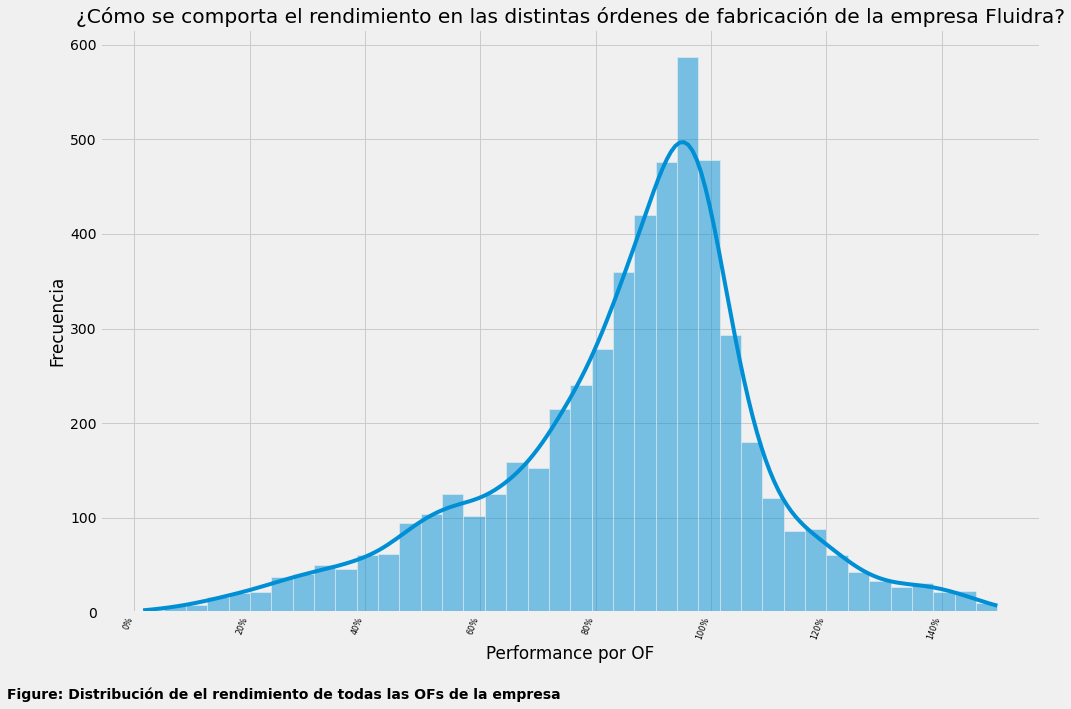

In [62]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 10))

# Crear un histograma con Seaborn
sns.histplot(data=df_of_cleaned, x='performance', bins=40, kde=True, ax=ax)

# Añadir un título y etiquetas de los ejes
ax.set_title("¿Cómo se comporta el rendimiento en las distintas órdenes de fabricación de la empresa Fluidra?")
ax.set_xlabel("Performance por OF")
ax.set_xticklabels(df_of_cleaned.performance.unique(), rotation=70, ha='right', fontsize=8)
ax.set_ylabel("Frecuencia")
ax.xaxis.set_major_formatter(percentage_formatter)

# Añadir pie de figura
fig.text(0.25, -0.05, "Figure: Distribución de el rendimiento de todas las OFs de la empresa", ha='center', weight='bold')

# Mostrar el gráfico
plt.show()

Para poder analizar el comportamiento descrito en la pregunta, se ha seleccionado un gráfico tipo histograma para poder visualizar la distribución de la performance en las distintas OFs. Como se puede observar, la mayoria de OFs se encuentran muy cercanos al 100% de performance. Aún asi, con este gráfico podemos ver cómo hay performances bastantes bajas e incluso performances mayores al 100%. Con esta distribución podemos tambien observar que sigue una distribución normal.

#### Análisis del rendimiento por el tipo de bombas

En este caso,como existen unos 724 tipos de bombas, vamos a dividir estos tipos de bombas según sus tiempos de teóricos. Asi podremos analizar mejor los tipos de bombas.

In [63]:
df_of_cleaned['theorical_time'].max()

96.0

In [64]:
print(f'Tiempo mínimo de fabricación de bomba: {df_of_cleaned["theorical_time"].min()}')
print(f'Tiempo máximo de fabricación de bomba: {df_of_cleaned["theorical_time"].max()}')

Tiempo mínimo de fabricación de bomba: 0.5
Tiempo máximo de fabricación de bomba: 96.0


Podemos observar que las bombas más rapidas de montar son unos 30 segundos y las maximas 96 minutos. Vamos a crear 4 grupos para clasificar estos tipos de bombas.

* Grupo 1: >= 0.5 & < 24 min
* Grupo 2: >= 24 & < 48 min
* Grupo 3: >= 48 & < 72 min
* Grupo 4: >= 72

In [65]:
# Definir los rangos para cada grupo y los nombres de cada grupo
bins = [0.5, 24.0, 48.0, 72.0, float('inf')]
labels = ['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4']

# Crear un nuevo dataframe con las columnas 'grupo_bomba' y 'media_rendimiento'
df_bombs_performance = df_of_cleaned.groupby(pd.cut(df_of_cleaned['theorical_time'], bins=bins, labels=labels))['performance'].agg(['mean', 'std']).reset_index()
df_bombs_performance.columns = ['bomb_group', 'performance','standard_deviation']

df_bombs_performance

,bomb_group,performance,standard_deviation
0,Grupo 1,0.843916,0.239075
1,Grupo 2,1.005112,0.268478
2,Grupo 3,0.838882,0.188190
3,Grupo 4,0.907825,0.177718


De aquí podemos observar como realmente los grupos de bombas más eficientes serían los grupos 2 y 4. Sin embargo, el grupo 1 y 4 no estan muy lejos teniendo en cuenta las desviaciones de cada uno.

El grupo "Grupo 2" tiene la media más alta de rendimiento, pero también la desviación estándar más alta, lo que sugiere una mayor variabilidad en los valores de rendimiento. El grupo "Grupo 3" tiene una media de rendimiento similar al grupo "Grupo 1", pero con una desviación estándar menor, lo que sugiere una mayor consistencia en los valores de rendimiento. En conclusión, aunque el grupo "Grupo 2" tiene la media más alta de rendimiento, el grupo "Grupo 3" puede considerarse más eficiente debido a su menor variabilidad en los valores de rendimiento.

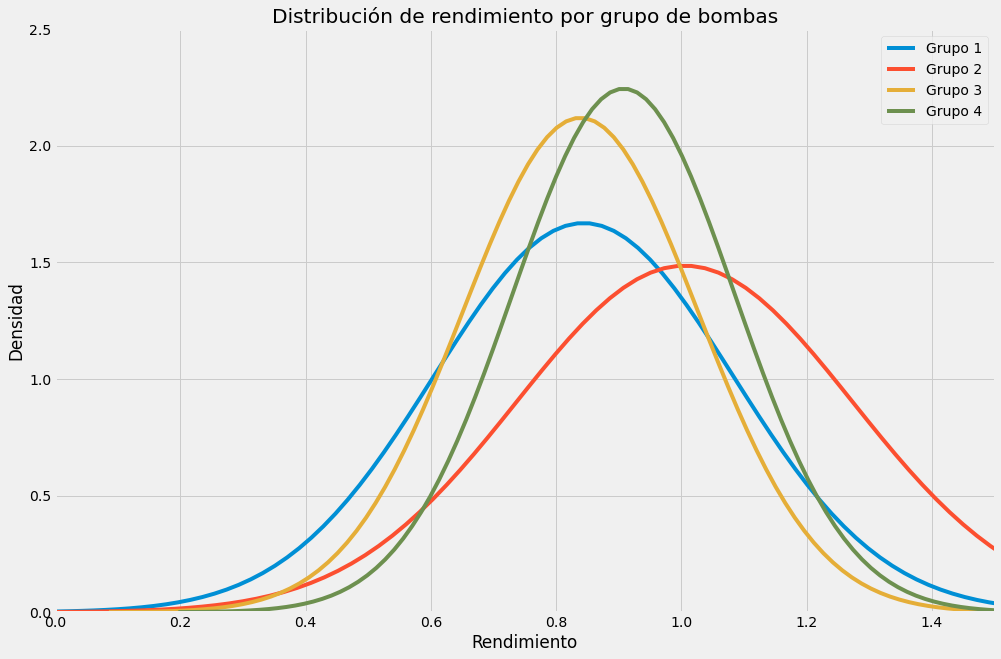

In [66]:
import numpy as np

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(15, 10))

# Crear una distribución de densidad para cada grupo
for i, row in df_bombs_performance.iterrows():
    group = row['bomb_group']
    mean = row['performance']
    std_dev = row['standard_deviation']
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100)
    y = 1 / (std_dev * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    ax.plot(x, y, label=group)

# Configurar los límites de los ejes y los títulos
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 2.5)
ax.set_title('Distribución de rendimiento por grupo de bombas')
ax.set_xlabel('Rendimiento')
ax.set_ylabel('Densidad')
ax.legend()

# Mostrar el gráfico
plt.show()

#### Análisis del rendimiento por tiempo

Vamos a visualizar el rendimiento según días.

In [67]:
data = df_of_cleaned.copy()
# Crear una columna solo con el mes y el día
data['month'] = data.end_date.dt.strftime('%m')

# Agrupar por año, mes y día, y calcular la cantidad de producción diaria
data_daily = data.groupby([data.end_date.dt.year, 'month'])['performance'].mean().reset_index()
data_daily.columns = ['year', 'month', 'performance']

data_daily.head()

,year,month,performance
0,2020,01,0.853972
1,2020,02,0.892257
2,2020,03,0.927320
3,2020,04,0.939697
4,2020,05,0.934252


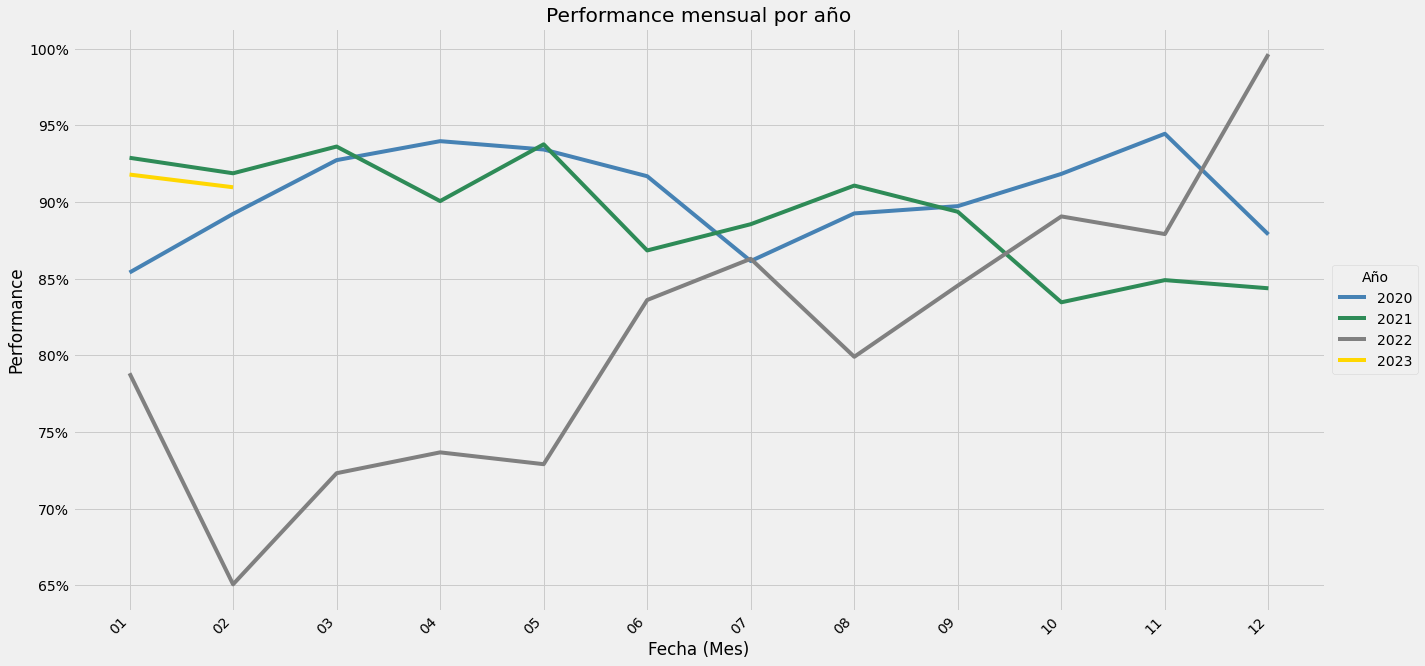

In [68]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Obtener los años únicos
unique_years = data_daily['year'].unique()

# Colors
color_pal = sns.color_palette(['steelblue', 'seagreen', 'gray', 'gold', 'magenta', 'yellow'])

for i, year in enumerate(unique_years):
    yearly_data = data_daily[data_daily['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['performance'], label=str(int(year)), color=color_pal[i])

plt.xlabel('Fecha (Mes)')
plt.ylabel('Performance')
plt.title('Performance mensual por año')

# Aplicar el formateador al eje y
plt.gca().yaxis.set_major_formatter(percentage_formatter)

# Mover la leyenda a la derecha
plt.legend(title='Año', loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(rotation=45, ha='right')
plt.show()

Realmente con el anterior gráfico, no podemos sacar conclusiones claras. Ya que no indica nada que según el més haya un rendimiento peor, podemos observar algún comportamiento raro al inicio del 2022.

In [69]:
# Crear una columna con el nombre de la estación
data['season'] = pd.cut(data['end_date'].dt.month, [0,3,6,9,12], labels=['Invierno','Primavera','Verano','Otoño'])

# Agrupar por año y estación, y calcular la media y la desviación estándar de la performance
data_seasonal = data.groupby([data['end_date'].dt.year, 'season'])['performance'].agg([np.mean, np.std]).reset_index()
data_seasonal.columns = ['year', 'season', 'mean_performance', 'std_performance']

data_seasonal.head()

,year,season,mean_performance,std_performance
0,2020,Invierno,0.888686,0.189462
1,2020,Primavera,0.928195,0.197172
2,2020,Verano,0.876513,0.200091
3,2020,Otoño,0.918007,0.184959
4,2021,Invierno,0.928065,0.181358


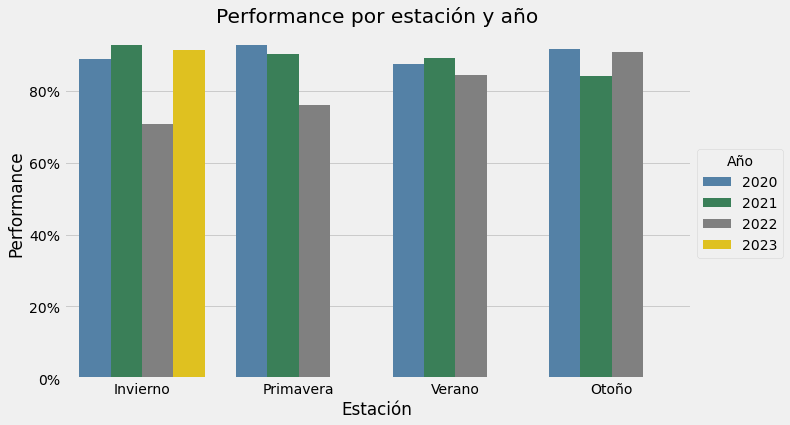

In [70]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Colors
color_pal = sns.color_palette(['steelblue', 'seagreen', 'gray', 'gold'])

# Plotear los datos
sns.barplot(x='season', y='mean_performance', hue='year', data=data_seasonal, palette=color_pal, ax=ax)
sns.despine()

# Aplicar el formateador al eje y
plt.gca().yaxis.set_major_formatter(percentage_formatter)

# Agregar título y etiquetas
plt.title('Performance por estación y año')
plt.xlabel('Estación')
plt.ylabel('Performance')

# Mover la leyenda a la derecha
plt.legend(title='Año', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

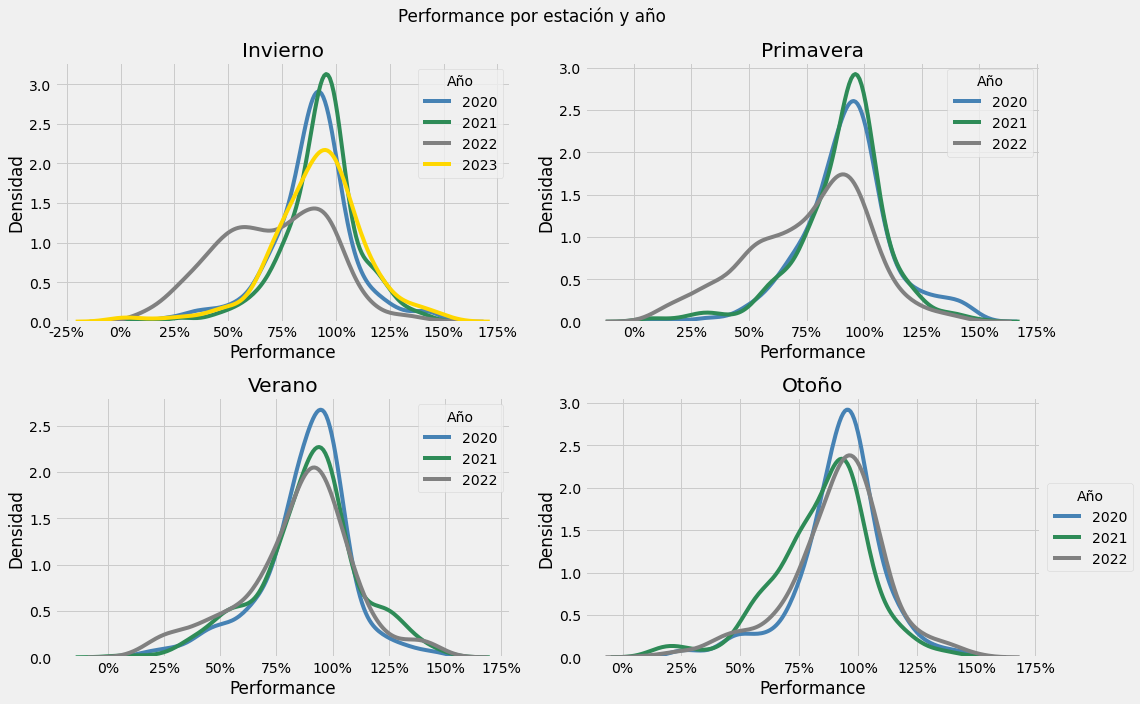

In [71]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 10))

# Colors
color_pal = sns.color_palette(['steelblue', 'seagreen', 'gray', 'gold'])

# Plotear los datos
sns.barplot(x='season', y='mean_performance', hue='year', data=data_seasonal, palette=color_pal, ax=ax)
sns.despine()

# Agregar las distribuciones de densidad (KDE)
for i, season in enumerate(data_seasonal['season'].unique()):
    season_data = data[data['season'] == season]
    ax = plt.subplot(2, 2, i+1)
    for year in data_seasonal[data_seasonal['season'] == season]['year']:
        year_data = season_data[season_data['end_date'].dt.year == year]
        sns.kdeplot(year_data['performance'], shade=False, label=year, ax=ax, color=color_pal[year-data_seasonal['year'].min()])
    ax.set_title(season)
    ax.set_xlabel('Performance')
    ax.set_ylabel('Densidad')
    ax.legend(title='Año')
    # Aplicar el formateador al eje y
    plt.gca().xaxis.set_major_formatter(percentage_formatter)

# Agregar título y etiquetas
plt.suptitle('Performance por estación y año')
plt.tight_layout()

# Mover la leyenda a la derecha
plt.legend(title='Año', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [72]:
# Calcular la media de performance de todos los años en cada estación, excluyendo el año 2023
overall_means = data_seasonal[data_seasonal['year'] != 2023].groupby('season')['mean_performance'].mean().reset_index()

overall_means.head()

,season,mean_performance
0,Invierno,0.841724
1,Primavera,0.864836
2,Verano,0.871746
3,Otoño,0.890189


Podemos ver como no existe mucha diferencia versus el rendimiento y estaciones/tiempo. Aún así, buscamos todos los periodos dónde las empresas tuvieron que cerrar por culpa del COVID. A ver si observamos alguna diferencia.

In [73]:
data = df_of_cleaned.copy()
# Crear una columna solo con el mes y el día
data['month'] = data.end_date.dt.strftime('%m')

# Agrupar por año, mes y día, y calcular la cantidad de producción diaria
data_daily = data.groupby([data.end_date.dt.year, 'month']).agg({'good_qty': 'sum', 'performance': 'mean'}).reset_index()
data_daily.columns = ['year', 'month', 'good_qty','performance']

data_daily.head()

,year,month,good_qty,performance
0,2020,01,13566.0,0.853972
1,2020,02,18700.0,0.892257
2,2020,03,12926.0,0.927320
3,2020,04,5195.0,0.939697
4,2020,05,11239.0,0.934252


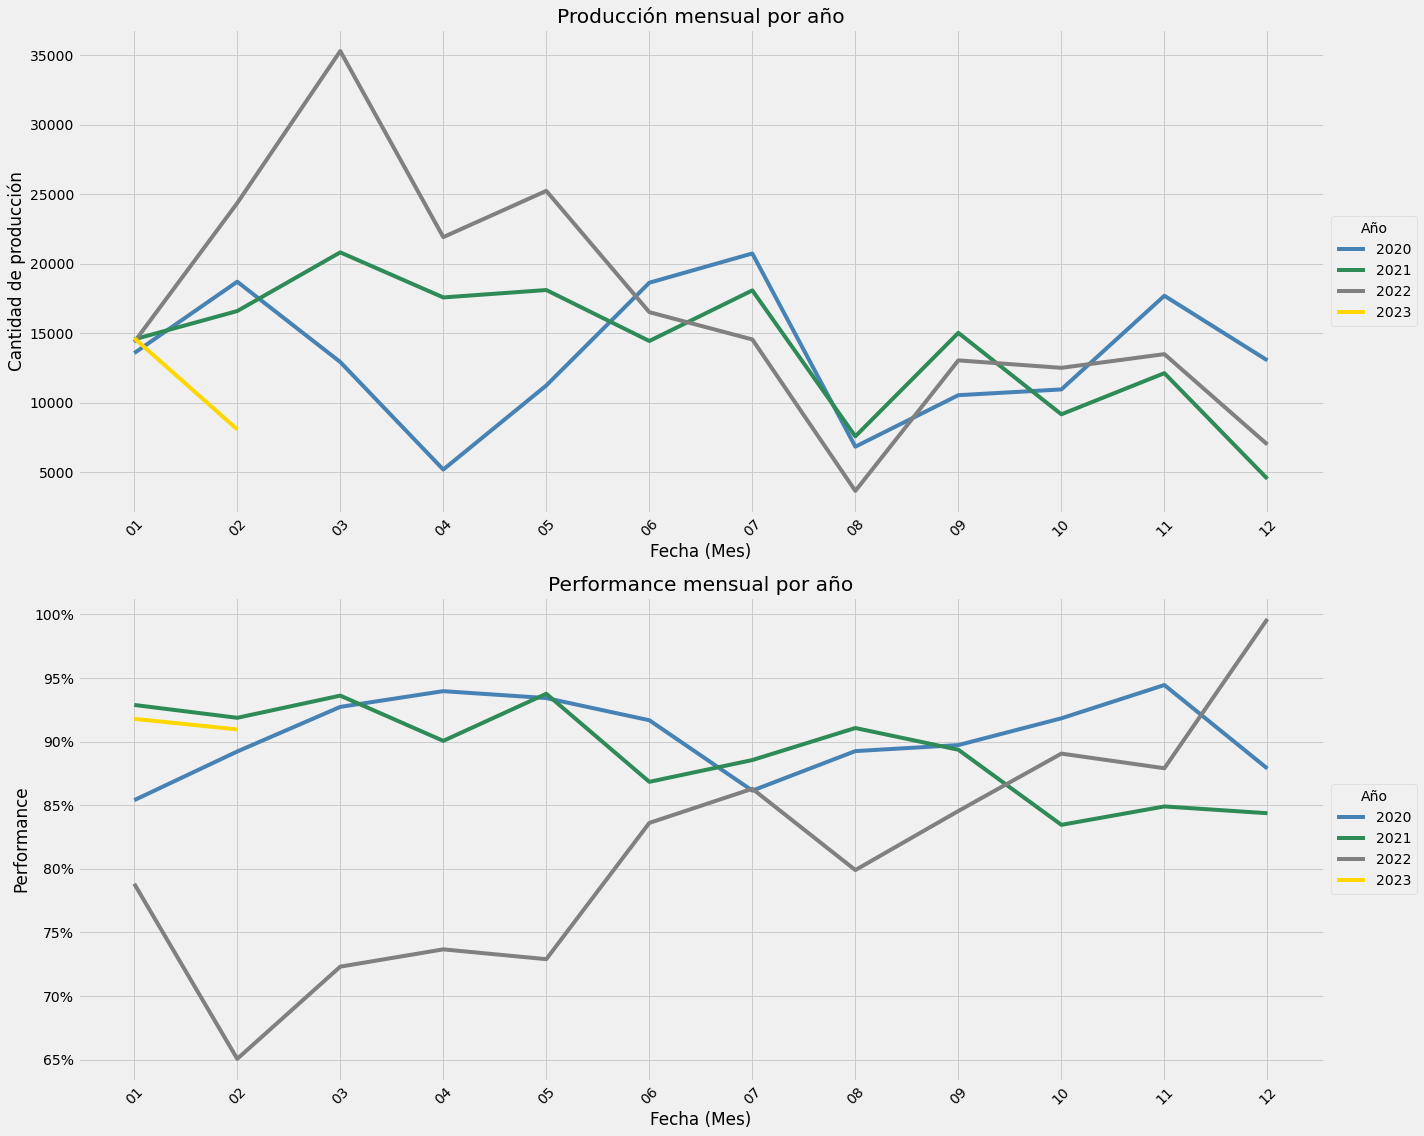

In [74]:
# Crear figura y ejes con dos subplots
fig, ax = plt.subplots(nrows=2, figsize=(20, 16))

# Obtener los años únicos
unique_years = data_daily['year'].unique()

# Colors
color_pal = sns.color_palette(['steelblue', 'seagreen', 'gray', 'gold', 'magenta', 'yellow'])

# Plotear el gráfico de producción en el primer subplot
for i, year in enumerate(unique_years):
    yearly_data = data_daily[data_daily['year'] == year]
    ax[0].plot(yearly_data['month'], yearly_data['good_qty'], label=str(int(year)), color=color_pal[i])

ax[0].set_xlabel('Fecha (Mes)')
ax[0].set_ylabel('Cantidad de producción')
ax[0].set_title('Producción mensual por año')
ax[0].legend(title='Año', loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].tick_params(axis='x', rotation=45)

# Plotear el gráfico de performance en el segundo subplot
for i, year in enumerate(unique_years):
    yearly_data = data_daily[data_daily['year'] == year]
    ax[1].plot(yearly_data['month'], yearly_data['performance'], label=str(int(year)), color=color_pal[i])

ax[1].set_xlabel('Fecha (Mes)')
ax[1].set_ylabel('Performance')
ax[1].set_title('Performance mensual por año')
ax[1].legend(title='Año', loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].tick_params(axis='x', rotation=45)
ax[1].yaxis.set_major_formatter(percentage_formatter)

# Ajustar los subplots para que no se superpongan
fig.tight_layout()

# Mostrar el gráfico
plt.show()

No parece haber una relación muy clara temporalmente entre la producción y la performance. Se podria intentar mirar mejor si existe relación...

#### Análisis del rendimiento por usuario

In [75]:
df_of_only_operators = df_of_cleaned[df_of_cleaned.operators_distinct_qty == 1]

df_of_only_operators.head()

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,[5025],8,1,2.458296,2.0,0.813572,1.000000
10,5160396,1210,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:53:20.250,2020-01-02 08:59:16.247,11156,85.00,11155.997,185.933283,185.933283,[5025],4,1,2.187450,2.0,0.914306,1.000000
11,5160572,1195,LÍNEA 1,6.0,6.0,0.0,6.0,0.0,2020-01-24 11:01:17.000,2020-01-27 12:04:23.617,33014,80.00,33015.444,550.257400,550.257400,[5025],12,1,6.878218,7.0,0.872319,0.857143
21,5163096,20026,PREFILTRO L-1,12.0,12.0,0.0,12.0,0.0,2020-01-09 07:41:16.407,2020-01-09 10:15:28.000,9252,9.83,9251.593,154.193217,154.193217,[5025],3,1,15.685983,16.0,0.765014,0.750000
25,5164400,1193,LÍNEA 1,11.0,11.0,0.0,11.0,0.0,2020-01-15 07:07:46.370,2020-01-16 13:47:57.873,53227,80.00,53227.470,887.124500,887.124500,[5025],11,1,11.089056,11.0,0.991969,1.000000


In [76]:
df_of_only_operators['operators_distinct_ids'] = df_of_only_operators['operators_distinct_ids'].map(tuple)
valores_distintos = df_of_only_operators['operators_distinct_ids'].unique()
len(valores_distintos)

/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


25

In [77]:
# Agrupamos una tabla con la media de rendimiento por los operarios que han trabajado sólos
df_performance_by_only_operators = df_of_only_operators.groupby('operators_distinct_ids')['performance'].mean()
# Mostramos sólo el ID del operario
df_performance_by_only_operators.index = df_performance_by_only_operators.index.map(lambda x: x[0])

# Convertir la serie en un dataframe y resetear el índice
df_performance_by_only_operators = df_performance_by_only_operators.to_frame().reset_index()

# Mostrar el dataframe resultante
df_performance_by_only_operators.head()


,operators_distinct_ids,performance
0,1007,0.900522
1,5004,0.891670
2,5015,0.933687
3,5020,0.985468
4,5025,0.927032


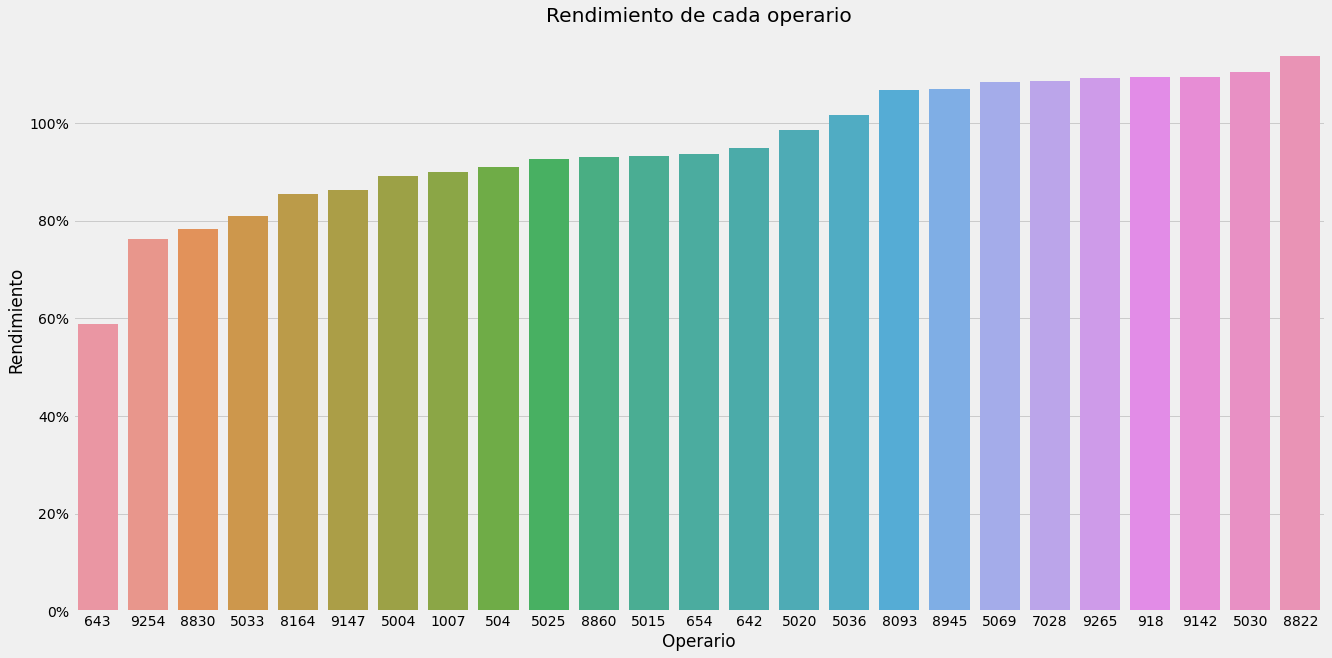

In [78]:
df_performance_by_only_operators = df_performance_by_only_operators.sort_values('performance')

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Crear un histograma con Seaborn
sns.barplot(data=df_performance_by_only_operators, x='operators_distinct_ids', y='performance')

# Añadir un título y etiquetas de los ejes
plt.xlabel('Operario')
plt.ylabel('Rendimiento')
plt.title('Rendimiento de cada operario')
ax.yaxis.set_major_formatter(percentage_formatter)

# Mostrar el gráfico
plt.show()

In [79]:
# Agrupamos una tabla con la media y desviación estándar del rendimiento por los operarios que han trabajado sólos
df_performance_by_only_operators = df_of_only_operators.groupby('operators_distinct_ids')['performance'].agg(['mean', 'std'])

# Mostramos sólo el ID del operario
df_performance_by_only_operators.index = df_performance_by_only_operators.index.map(lambda x: x[0])

# Resetear el índice del dataframe
df_performance_by_only_operators = df_performance_by_only_operators.reset_index()

# Renombrar las columnas
df_performance_by_only_operators = df_performance_by_only_operators.rename(columns={'operators_distinct_ids': 'operators_distinct_ids', 'mean': 'performance_mean', 'std': 'performance_std'})

# Ordenar el dataframe por la columna "Media" de menor a mayor
df_performance_by_only_operators = df_performance_by_only_operators.sort_values('performance_mean')

# Mostrar el dataframe resultante
df_performance_by_only_operators.head()

,operators_distinct_ids,performance_mean,performance_std
11,643,0.588461,0.345380
23,9254,0.763087,0.152380
17,8830,0.783647,NaN
6,5033,0.809710,0.196139
15,8164,0.855103,0.264852


/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


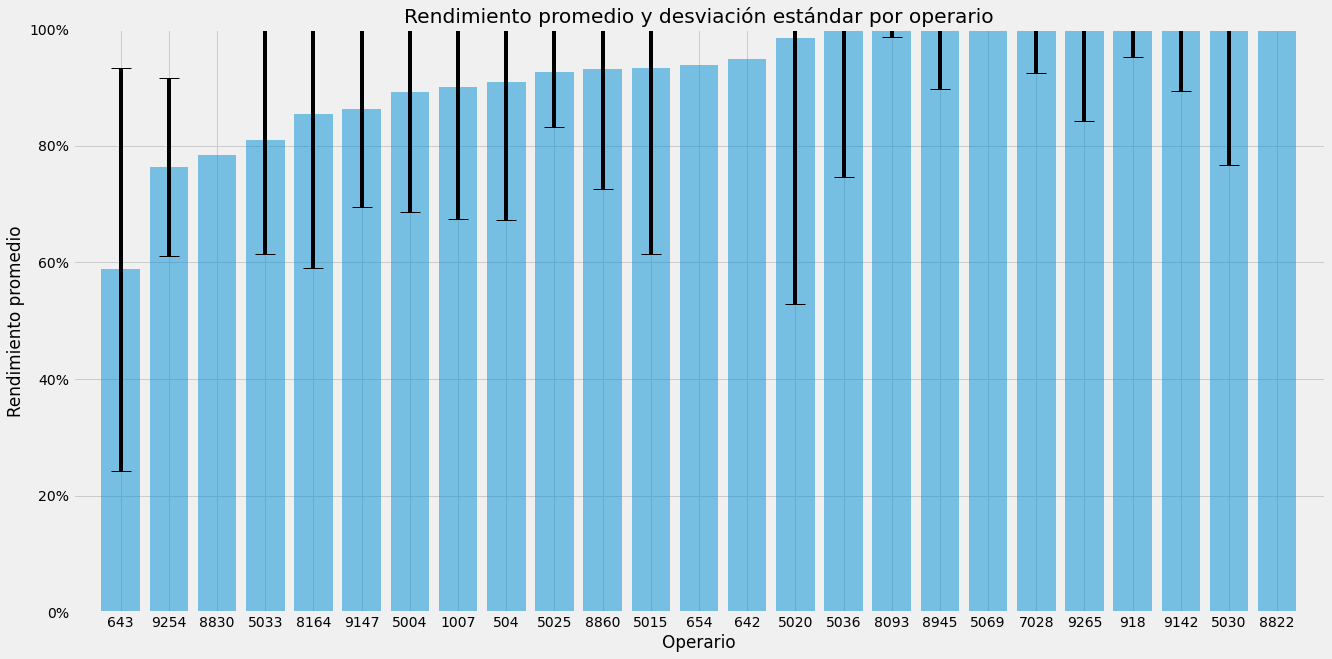

In [80]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Definir los datos
x = df_performance_by_only_operators['operators_distinct_ids']
y = df_performance_by_only_operators['performance_mean']
error = df_performance_by_only_operators['performance_std']

# Dibujar el gráfico de barras con error
ax.bar(x, y, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)

# Establecer el título y etiquetas de los ejes
ax.set_title('Rendimiento promedio y desviación estándar por operario')
ax.set_xlabel('Operario')
ax.set_ylabel('Rendimiento promedio')

ax.yaxis.set_major_formatter(percentage_formatter)

# Ajustar los límites de los ejes x e y
ax.set_xlim(left=-1, right=len(x))
ax.set_ylim(bottom=0, top=1)

# Mostrar el gráfico
plt.show()

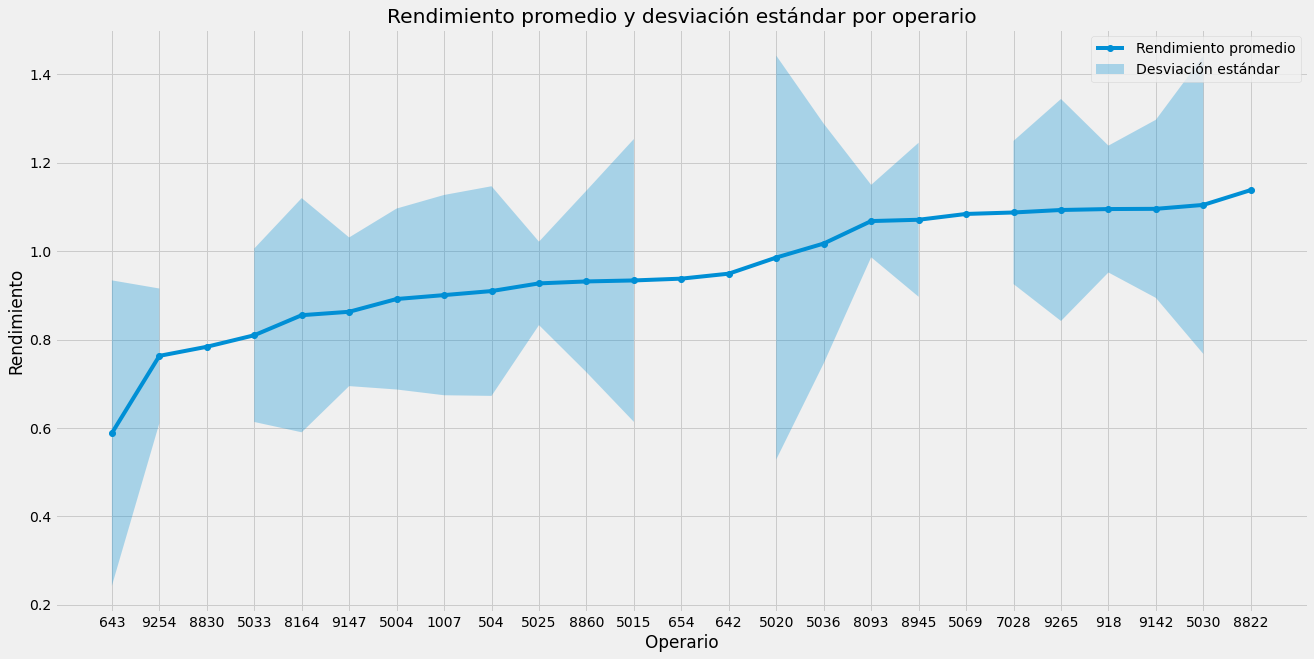

In [81]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Dibujar las líneas de rendimiento promedio y desviación estándar
ax.plot(df_performance_by_only_operators['operators_distinct_ids'], df_performance_by_only_operators['performance_mean'], marker='o', label='Rendimiento promedio')
ax.fill_between(df_performance_by_only_operators['operators_distinct_ids'], df_performance_by_only_operators['performance_mean']-df_performance_by_only_operators['performance_std'], df_performance_by_only_operators['performance_mean']+df_performance_by_only_operators['performance_std'], alpha=0.3, label='Desviación estándar')

# Establecer el título y etiquetas de los ejes
ax.set_title('Rendimiento promedio y desviación estándar por operario')
ax.set_xlabel('Operario')
ax.set_ylabel('Rendimiento')

# Añadir leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

#### Graficos para el proyecto de Pere

In [82]:
df_of_cleaned

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,1391,8.21,1390.997,23.183283,46.366567,"[5015, 5036]",2,2,5.647572,6.0,1.416538,1.333333
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,[5025],8,1,2.458296,2.0,0.813572,1.000000
5,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"[1007, 504, 8945, 287]",2,4,11.835761,12.0,1.013877,1.000000
6,5158571,11509INT,LINEA 6,48.0,48.0,0.0,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,"[504, 8945, 7028]",7,3,57.163126,57.0,0.839702,0.842105
7,5159132,65566,LINEA 3,330.0,330.0,0.0,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,"[8721, 1007]",20,2,255.628316,256.0,0.692412,0.691406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456,5379842,65562,LÍNEA 2,540.0,540.0,0.0,540.0,0.0,2023-02-09 13:00:06.627,2023-02-10 16:23:59.713,71526,6.87,71526.036,1192.100600,3994.120200,"[9280, 8830, 8615, 9122, 918, 8230, 287]",54,7,581.385764,581.0,0.928815,0.929432
5457,5379871,SA125MFLDFRA,LINEA 8 IML,10.0,10.0,0.0,10.0,0.0,2023-02-10 10:46:11.787,2023-02-10 11:11:22.370,1511,9.70,1510.583,25.176383,71.664083,"[9279, 9109, 9351, 8250]",15,4,7.388050,7.0,1.353537,1.428571
5458,5381228,65570H,LÍNEA 2,150.0,150.0,0.0,150.0,0.0,2023-02-08 12:50:17.953,2023-02-08 19:17:01.463,23204,6.87,23203.510,386.725167,1102.333133,"[9280, 8830, 8615, 9122, 918, 8230, 287]",18,7,160.456060,160.0,0.934835,0.937500
5459,5382059,6862,LINEA 7,66.0,66.0,0.0,66.0,0.0,2023-02-07 12:19:03.143,2023-02-08 13:41:29.470,34151,8.50,34150.804,569.180067,569.180067,[9254],5,1,66.962361,67.0,0.985628,0.985075


/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


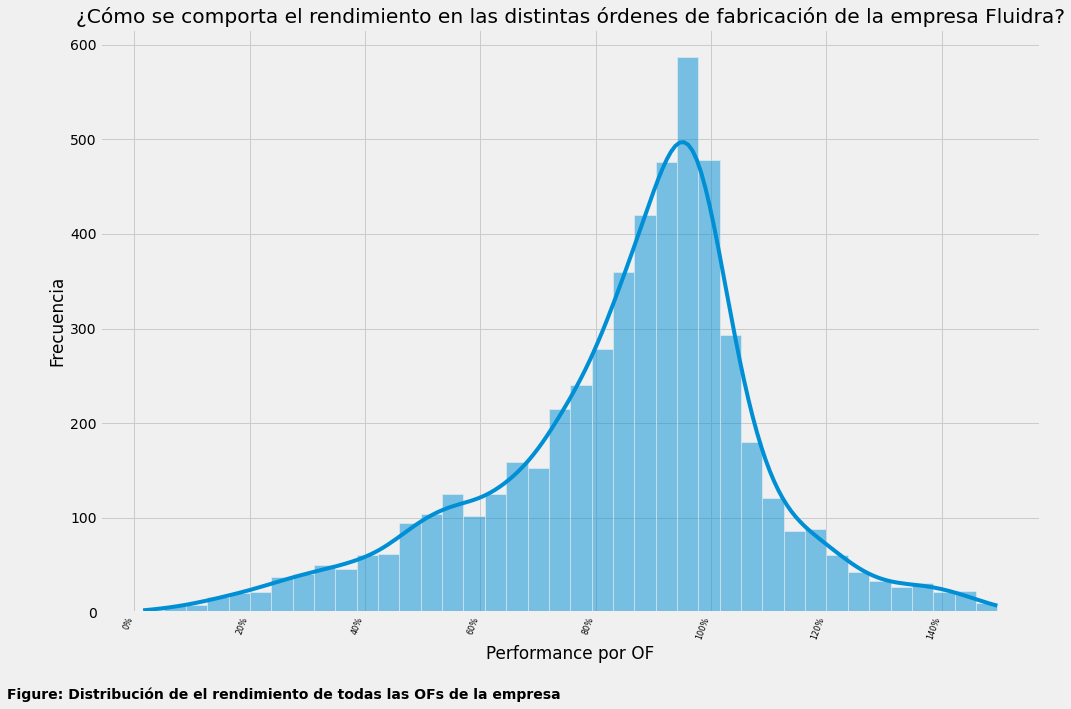

In [83]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 10))

# Crear un histograma con Seaborn
sns.histplot(data=df_of_cleaned, x='performance', bins=40, kde=True, ax=ax)

# Añadir un título y etiquetas de los ejes
ax.set_title("¿Cómo se comporta el rendimiento en las distintas órdenes de fabricación de la empresa Fluidra?")
ax.set_xlabel("Performance por OF")
ax.set_xticklabels(df_of_cleaned.performance.unique(), rotation=70, ha='right', fontsize=8)
ax.set_ylabel("Frecuencia")
ax.xaxis.set_major_formatter(percentage_formatter)

# Añadir pie de figura
fig.text(0.25, -0.05, "Figure: Distribución de el rendimiento de todas las OFs de la empresa", ha='center', weight='bold')

# Mostrar el gráfico
plt.show()

Para poder analizar el comportamiento descrito en la pregunta, se ha seleccionado un gráfico tipo histograma para poder visualizar la distribución de la performance en las distintas OFs. Como se puede observar, la mayoria de OFs se encuentran muy cercanos al 100% de performance. Aún asi, con este gráfico podemos ver cómo hay performances bastantes bajas e incluso performances mayores al 100%. Con esta distribución podemos tambien observar que sigue una distribución normal.

In [84]:
# Ordenar los datos por cantidades reales de menor a mayor
df_good_qty_sorted = df_of_cleaned[df_of_cleaned.good_qty <= 1000].sort_values('good_qty')


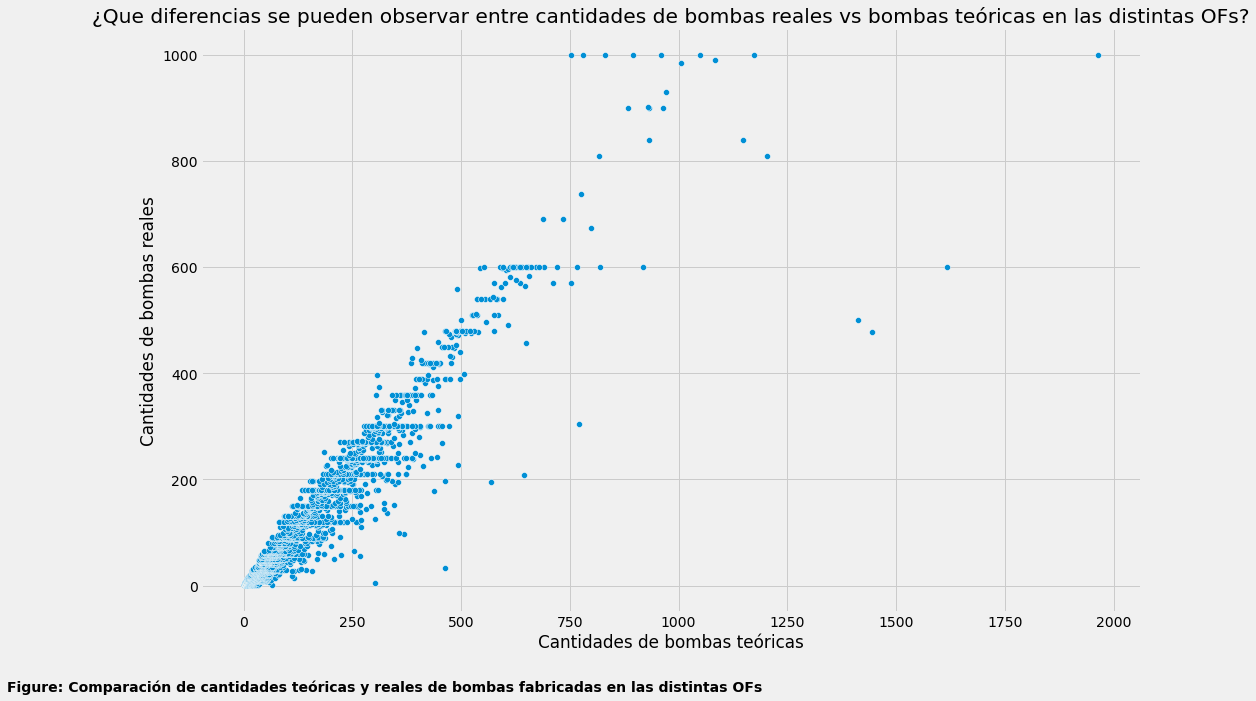

In [85]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 10))

# Crear un gráfico de dispersión con las cantidades teóricas y reales con Seaborn
sns.scatterplot(data=df_good_qty_sorted, x='theorical_qty', y='good_qty')

# Añadir un título y etiquetas de los ejes
ax.set_title("¿Que diferencias se pueden observar entre cantidades de bombas reales vs bombas teóricas en las distintas OFs?")
ax.set_xlabel("Cantidades de bombas teóricas")
ax.set_ylabel("Cantidades de bombas reales")

# Añadir pie de figura
fig.text(0.25, -0.04, "Figure: Comparación de cantidades teóricas y reales de bombas fabricadas en las distintas OFs", ha='center', weight='bold')


# Mostrar el gráfico
plt.show()

En el anterior gráfico se puede observar la dispersión que hay entre las cantidades de bombas teóricas vs las reales. Sepuede observar una tendencia lineal entre las bombas teóricas vs las reales. En este caso sólo se han cogido las ordenes de fabricación con menos de 1000 bombas fabricadas, ya que sino distorsionaban mucho el gràfico.

In [86]:
df_of_cleaned

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,1391,8.21,1390.997,23.183283,46.366567,"[5015, 5036]",2,2,5.647572,6.0,1.416538,1.333333
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,[5025],8,1,2.458296,2.0,0.813572,1.000000
5,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"[1007, 504, 8945, 287]",2,4,11.835761,12.0,1.013877,1.000000
6,5158571,11509INT,LINEA 6,48.0,48.0,0.0,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,"[504, 8945, 7028]",7,3,57.163126,57.0,0.839702,0.842105
7,5159132,65566,LINEA 3,330.0,330.0,0.0,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,"[8721, 1007]",20,2,255.628316,256.0,0.692412,0.691406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456,5379842,65562,LÍNEA 2,540.0,540.0,0.0,540.0,0.0,2023-02-09 13:00:06.627,2023-02-10 16:23:59.713,71526,6.87,71526.036,1192.100600,3994.120200,"[9280, 8830, 8615, 9122, 918, 8230, 287]",54,7,581.385764,581.0,0.928815,0.929432
5457,5379871,SA125MFLDFRA,LINEA 8 IML,10.0,10.0,0.0,10.0,0.0,2023-02-10 10:46:11.787,2023-02-10 11:11:22.370,1511,9.70,1510.583,25.176383,71.664083,"[9279, 9109, 9351, 8250]",15,4,7.388050,7.0,1.353537,1.428571
5458,5381228,65570H,LÍNEA 2,150.0,150.0,0.0,150.0,0.0,2023-02-08 12:50:17.953,2023-02-08 19:17:01.463,23204,6.87,23203.510,386.725167,1102.333133,"[9280, 8830, 8615, 9122, 918, 8230, 287]",18,7,160.456060,160.0,0.934835,0.937500
5459,5382059,6862,LINEA 7,66.0,66.0,0.0,66.0,0.0,2023-02-07 12:19:03.143,2023-02-08 13:41:29.470,34151,8.50,34150.804,569.180067,569.180067,[9254],5,1,66.962361,67.0,0.985628,0.985075


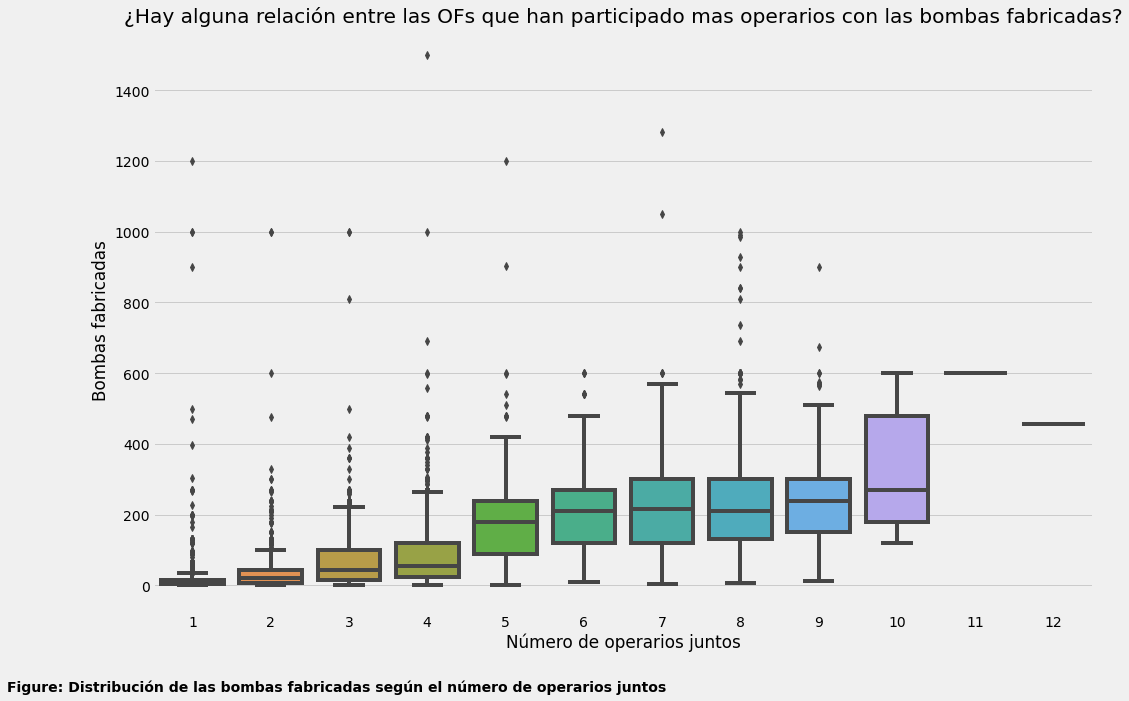

In [87]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 10))

# Crear un gráfico de boxplot con Seaborn
sns.boxplot(data=df_of_cleaned[df_of_cleaned.good_qty < 2000], x='operators_distinct_qty', y='good_qty')

# Añadir un título y etiquetas de los ejes
ax.set_title("¿Hay alguna relación entre las OFs que han participado mas operarios con las bombas fabricadas?")
ax.set_xlabel("Número de operarios juntos")
ax.set_ylabel("Bombas fabricadas")

# Añadir pie de figura
fig.text(0.25, -0.04, "Figure: Distribución de las bombas fabricadas según el número de operarios juntos", ha='center', weight='bold')

# Mostrar el gráfico
plt.show()

El gráfico anterior muestra la distribución en un gráfico boxplot sobre la cantidad de bombas fabricadas entre las órdenes de fabricación con diferentes cantidades de operarios, y sirve para detectar posibles valores atípicos. Además, permite identificar si existe alguna relación entre la cantidad de operarios y la cantidad de bombas fabricadas. Se puede observar como hay una tendencia creciente de bombas fabricadas cuantos más operarios trabajan juntos. Sin embargo, se puede ver como hay pocas OFs que trabajen 11 o 12 operarios a parte de que se observa una caída de bombas fabricadas con 12 operarios.

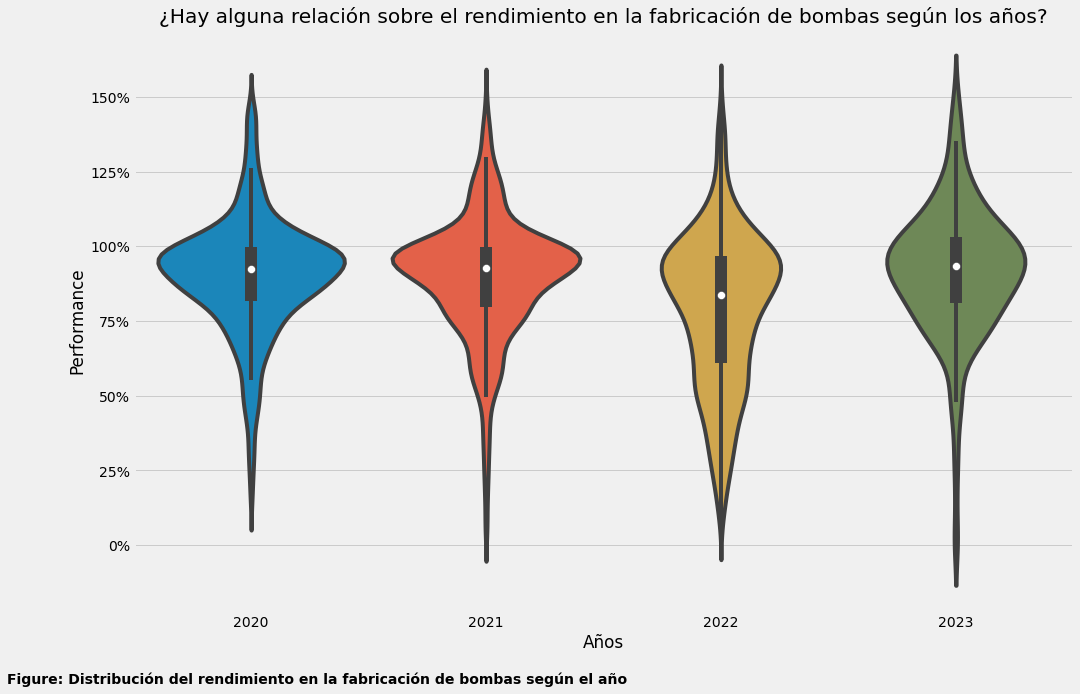

In [88]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 10))

# Crear un gráfico de violin con Seaborn
sns.violinplot(data=df_of_cleaned, x=df_of_cleaned['end_date'].dt.year, y='performance')

# Añadir un título y etiquetas de los ejes
ax.set_title("¿Hay alguna relación sobre el rendimiento en la fabricación de bombas según los años?")
ax.set_xlabel("Años")
ax.set_ylabel("Performance")
ax.yaxis.set_major_formatter(percentage_formatter)

# Añadir pie de figura
fig.text(0.25, -0.03, "Figure: Distribución del rendimiento en la fabricación de bombas según el año", ha='center', weight='bold')

# Mostrar el gráfico
plt.show()

En el anterior gráfico se puede observar en un gráfico de tipo violín la distribución de la performance según el año. Una observación sobre el gráfico anterior es que la mayoria de perfomnaces estan en todos los años en los 80-95%. Sin embargo, se puede observar como en el 2022 hay rendimientos bastantes peores del 75%. Las distribuciones del 2020 y 2021 són bastante parecidas y posteriormente las distribuciones són peores.

## Análisis post feedback
### Análisis tiempo apertura y cierre de OFs vs tiempo dedicado OF

In [89]:
df_of_cleaned.head()

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,1391,8.21,1390.997,23.183283,46.366567,"[5015, 5036]",2,2,5.647572,6.0,1.416538,1.333333
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,[5025],8,1,2.458296,2.0,0.813572,1.000000
5,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"[1007, 504, 8945, 287]",2,4,11.835761,12.0,1.013877,1.000000
6,5158571,11509INT,LINEA 6,48.0,48.0,0.0,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,"[504, 8945, 7028]",7,3,57.163126,57.0,0.839702,0.842105
7,5159132,65566,LINEA 3,330.0,330.0,0.0,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,"[8721, 1007]",20,2,255.628316,256.0,0.692412,0.691406


A partir del anterior dataframe, calculamos el tiempo de la OF abierta vs el tiempo dedicado de OF.

In [91]:
df_of_cleaned_time = df_of_cleaned.copy()

df_of_cleaned_time.head()

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,1391,8.21,1390.997,23.183283,46.366567,"[5015, 5036]",2,2,5.647572,6.0,1.416538,1.333333
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,[5025],8,1,2.458296,2.0,0.813572,1.000000
5,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"[1007, 504, 8945, 287]",2,4,11.835761,12.0,1.013877,1.000000
6,5158571,11509INT,LINEA 6,48.0,48.0,0.0,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,"[504, 8945, 7028]",7,3,57.163126,57.0,0.839702,0.842105
7,5159132,65566,LINEA 3,330.0,330.0,0.0,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,"[8721, 1007]",20,2,255.628316,256.0,0.692412,0.691406


In [94]:
df_of_cleaned_time = df_of_cleaned_time[['start_date','end_date','time_diff_minutes_calculated']]

df_of_cleaned_time.head()

,start_date,end_date,time_diff_minutes_calculated
3,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,23.183283
4,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,210.380933
5,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,57.699333
6,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,372.054050
7,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,931.868767


In [98]:
df_of_cleaned_time['time_opened_of_minutes'] = ((df_of_cleaned_time['end_date']-df_of_cleaned_time['start_date']).dt.total_seconds())/60

df_of_cleaned_time.head()

,start_date,end_date,time_diff_minutes_calculated,time_opened_of_minutes
3,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,23.183283,23.183283
4,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,210.380933,1161.153383
5,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,57.699333,57.699333
6,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,372.054050,1320.317167
7,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,931.868767,1875.251383


Una vez tenemos el **time_diff_minutes_calculated** que es el tiempo dedicado a la OF vs el **time_opened_of_minutes**. Podemos comparar para ver cuantas OFs hay con el mismo valor dedicado y OFs abiertos.

In [101]:
# Formato no científico
pd.set_option('float_format', '{:.2f}'.format)

In [133]:
df_of_cleaned_time['time_diff_opened_vs_dedicated'] = abs(df_of_cleaned_time['time_opened_of_minutes']-df_of_cleaned_time['time_diff_minutes_calculated'])

df_of_cleaned_time.head()


,start_date,end_date,time_diff_minutes_calculated,time_opened_of_minutes,time_diff_opened_vs_dedicated
3,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,23.18,23.18,0.00
4,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,210.38,1161.15,950.77
5,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,57.70,57.70,0.00
6,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,372.05,1320.32,948.26
7,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,931.87,1875.25,943.38


In [134]:
df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated <= 10]

,start_date,end_date,time_diff_minutes_calculated,time_opened_of_minutes,time_diff_opened_vs_dedicated
3,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,23.18,23.18,0.00
5,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,57.70,57.70,0.00
10,2020-01-02 05:53:20.250,2020-01-02 08:59:16.247,185.93,185.93,0.00
13,2021-02-26 12:10:10.993,2021-02-26 13:13:17.017,63.10,63.10,0.00
18,2020-05-08 09:15:14.813,2020-05-08 10:23:49.243,68.57,68.57,0.00
...,...,...,...,...,...
5448,2023-02-10 07:11:38.853,2023-02-10 10:44:59.303,213.34,213.34,0.00
5449,2023-02-13 06:19:44.580,2023-02-13 07:38:14.120,78.49,78.49,0.00
5450,2023-01-27 07:05:06.230,2023-01-27 16:22:18.073,557.20,557.20,0.00
5457,2023-02-10 10:46:11.787,2023-02-10 11:11:22.370,25.18,25.18,0.00


In [140]:
# Cantidad de OFs
print(f'Número de OFs toal: {len(df_of_cleaned_time)}')

# Cantidad de OFs que tienen entre el tiempo dedicado y OF abierta <= 10 minutos
print(f'Número de OFs con diff tiempo dedicado y OF abierta <= 10min: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated <= 10])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated <= 10])/len(df_of_cleaned_time))*100} %')

# Cantidad de OFs que tienen entre el tiempo dedicado y OF abierta > 10 minutos
print(f'Número de OFs con diff tiempo dedicado y OF abierta > 10min: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated > 10])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated > 10])/len(df_of_cleaned_time))*100} %')

# Cantidad de OFs que tienen el mismo tiempo dedicado que tiempo de OF abierta
print(f'Número de OFs con mismo tiempo dedicado y OF abierta: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated == 0])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated == 0])/len(df_of_cleaned_time))*100} %')

# Cantidad de OFs que la diferencia entre el tiempo dedicado y OF abierta es mayor de 1 días
print(f'Número de OFs con diff tiempo dedicado y OF abierta > 1 día: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 1440])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 1440])/len(df_of_cleaned_time))*100} %')

# Cantidad de OFs que la diferencia entre el tiempo dedicado y OF abierta es mayor de 2 días
print(f'Número de OFs con diff tiempo dedicado y OF abierta > 2 día: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 2880])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 2880])/len(df_of_cleaned_time))*100} %')

# Cantidad de OFs que la diferencia entre el tiempo dedicado y OF abierta es mayor de 3 días
print(f'Número de OFs con diff tiempo dedicado y OF abierta > 3 día: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 4320])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 4320])/len(df_of_cleaned_time))*100} %')

# Cantidad de OFs que la diferencia entre el tiempo dedicado y OF abierta es mayor de 4 días
print(f'Número de OFs con diff tiempo dedicado y OF abierta > 4 día: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 5760])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 5760])/len(df_of_cleaned_time))*100} %')

# Cantidad de OFs que la diferencia entre el tiempo dedicado y OF abierta es mayor de 5 días
print(f'Número de OFs con diff tiempo dedicado y OF abierta > 5 día: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 7200])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 7200])/len(df_of_cleaned_time))*100} %')

# Cantidad de OFs que la diferencia entre el tiempo dedicado y OF abierta es mayor de 10 días
print(f'Número de OFs con diff tiempo dedicado y OF abierta > 5 día: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 14400])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 14400])/len(df_of_cleaned_time))*100} %')

# Cantidad de OFs que la diferencia entre el tiempo dedicado y OF abierta es mayor de 15 días
print(f'Número de OFs con diff tiempo dedicado y OF abierta > 5 día: {len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 21600])} | {(len(df_of_cleaned_time[df_of_cleaned_time.time_diff_opened_vs_dedicated >= 21600])/len(df_of_cleaned_time))*100} %')


Número de OFs toal: 5307
Número de OFs con diff tiempo dedicado y OF abierta <= 10min: 2359 | 44.45072545694366 %
Número de OFs con diff tiempo dedicado y OF abierta > 10min: 2948 | 55.549274543056335 %
Número de OFs con mismo tiempo dedicado y OF abierta: 1203 | 22.668174109666477 %
Número de OFs con diff tiempo dedicado y OF abierta > 1 día: 1191 | 22.442057659694743 %
Número de OFs con diff tiempo dedicado y OF abierta > 2 día: 831 | 15.65856416054268 %
Número de OFs con diff tiempo dedicado y OF abierta > 3 día: 499 | 9.402675711324665 %
Número de OFs con diff tiempo dedicado y OF abierta > 4 día: 273 | 5.144149236856981 %
Número de OFs con diff tiempo dedicado y OF abierta > 5 día: 182 | 3.4294328245713204 %
Número de OFs con diff tiempo dedicado y OF abierta > 5 día: 71 | 1.337855662332768 %
Número de OFs con diff tiempo dedicado y OF abierta > 5 día: 49 | 0.9233088373845865 %


In [141]:
df_of_cleaned_time.sort_values(by='time_diff_opened_vs_dedicated', ascending=False).head(10)


,start_date,end_date,time_diff_minutes_calculated,time_opened_of_minutes,time_diff_opened_vs_dedicated
3791,2022-03-25 11:03:21.157,2022-09-16 08:52:50.623,82.42,251869.49,251787.07
2909,2021-12-14 11:27:49.010,2022-03-31 07:21:22.777,258.88,153833.56,153574.68
1243,2020-10-01 09:24:09.077,2020-12-18 07:48:28.303,442.75,112224.32,111781.57
3522,2022-02-17 10:04:56.267,2022-05-05 09:17:47.623,324.34,110832.86,110508.51
3255,2022-02-02 05:50:35.170,2022-03-25 11:31:58.890,405.23,73781.40,73376.16
2496,2021-10-26 12:10:56.180,2021-12-14 11:04:55.997,189.85,70494.00,70304.14
3375,2022-01-27 11:27:53.097,2022-03-09 18:18:29.110,518.05,59450.60,58932.55
3079,2022-01-14 08:34:35.187,2022-02-22 17:47:59.850,499.63,56713.41,56213.78
2567,2022-02-10 18:23:52.960,2022-03-16 06:29:49.730,484.59,48245.95,47761.36
3840,2022-06-10 10:06:10.970,2022-07-11 10:17:38.833,120.82,44651.46,44530.64


**start_date:**
- 2022-03-25 11:03:21.157
- 2021-12-14 11:27:49.010
- 2020-10-01 09:24:09.077
- 2022-02-17 10:04:56.267
- 2022-02-02 05:50:35.170
- 2021-10-26 12:10:56.180
- 2022-01-27 11:27:53.097
- 2022-01-14 08:34:35.187
- 2022-02-10 18:23:52.960
- 2022-06-10 10:06:10.970

In [145]:
# Top 10 OFs que más tiempo ha estado abierta la OF
df_of_cleaned_time_top_10 = df_of_cleaned.copy()

df_of_cleaned_time_top_10['time_opened_of_minutes'] = ((df_of_cleaned_time_top_10['end_date']-df_of_cleaned_time_top_10['start_date']).dt.total_seconds())/60

df_of_cleaned_time_top_10['time_diff_opened_vs_dedicated'] = abs(df_of_cleaned_time_top_10['time_opened_of_minutes']-df_of_cleaned_time_top_10['time_diff_minutes_calculated'])

df_of_cleaned_time_top_10 = df_of_cleaned_time_top_10.sort_values(by='time_diff_opened_vs_dedicated', ascending=False)

df_of_cleaned_time_top_10.head(10)

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round,time_opened_of_minutes,time_diff_opened_vs_dedicated
3791,5321304,NI300M60ATEARB,LINEA 8 IML,13.00,13.00,0.00,13.00,0.00,2022-03-25 11:03:21.157,2022-09-16 08:52:50.623,4944,11.00,4945.00,82.42,329.67,"[8860, 7009, 9128, 9351, 9279, 9403]",23,6,29.97,30.00,0.43,0.43,251869.49,251787.07
2909,5294566,HGS101M,LINEA 3,57.00,57.00,0.00,57.00,0.00,2021-12-14 11:27:49.010,2022-03-31 07:21:22.777,15533,13.35,15533.01,258.88,778.09,"[504, 9147, 9324, 5033, 9265, 9352]",14,6,58.28,58.00,0.98,0.98,153833.56,153574.68
1243,5212415,1193,LÍNEA 1,6.00,6.00,0.00,6.00,0.00,2020-10-01 09:24:09.077,2020-12-18 07:48:28.303,26566,80.00,26565.06,442.75,444.55,"[5033, 5004]",15,2,5.56,6.00,1.08,1.00,112224.32,111781.57
3522,5316239,SE2R075M-B,LINEA 8 IML,120.00,90.00,0.00,90.00,0.00,2022-02-17 10:04:56.267,2022-05-05 09:17:47.623,19460,7.00,19460.49,324.34,1286.37,"[8860, 9378, 9359, 9351, 9406, 9279, 9379, 940...",106,9,183.77,184.00,0.49,0.49,110832.86,110508.51
3255,5308569,01226-0890,LÍNEA 1,3.00,3.00,0.00,3.00,0.00,2022-02-02 05:50:35.170,2022-03-25 11:31:58.890,24313,85.58,24314.03,405.23,425.63,"[5004, 9147]",12,2,4.97,5.00,0.60,0.60,73781.40,73376.16
2496,5270578,HGS101M,LINEA 3,4.00,4.00,0.00,4.00,0.00,2021-10-26 12:10:56.180,2021-12-14 11:04:55.997,11390,13.35,11391.15,189.85,349.00,"[504, 9109, 9265]",14,3,26.14,26.00,0.15,0.15,70494.00,70304.14
3375,5313934,SA100MIMLRUS,LINEA 8 IML,207.00,207.00,0.00,207.00,0.00,2022-01-27 11:27:53.097,2022-03-09 18:18:29.110,31083,6.50,31082.84,518.05,2066.52,"[8860, 9378, 9359, 9413, 9351, 9279, 9379, 9403]",228,8,317.93,318.00,0.65,0.65,59450.60,58932.55
3079,5304693,38769,LINEA 3,150.00,150.00,0.00,150.00,0.00,2022-01-14 08:34:35.187,2022-02-22 17:47:59.850,29977,9.10,29977.59,499.63,1726.47,"[504, 9265, 9421, 9396, 9147, 8164, 9324, 9422...",25,9,189.72,190.00,0.79,0.79,56713.41,56213.78
2567,5274683,M00964,LINEA 3,62.00,62.00,0.00,62.00,0.00,2022-02-10 18:23:52.960,2022-03-16 06:29:49.730,29077,10.00,29075.46,484.59,1012.92,"[9396, 9265, 8164, 9324, 8894, 9443, 9422, 9352]",18,8,101.29,101.00,0.61,0.61,48245.95,47761.36
3840,5322060,NI300T60ATEARB,LINEA 8 IML,16.00,16.00,0.00,16.00,0.00,2022-06-10 10:06:10.970,2022-07-11 10:17:38.833,7250,11.00,7249.28,120.82,470.99,"[9121, 9122, 9351, 9279, 9374, 9403]",27,6,42.82,43.00,0.37,0.37,44651.46,44530.64


In [156]:
df_of_cleaned_time[df_of_cleaned_time.time_diff_minutes_calculated > df_of_cleaned_time.time_opened_of_minutes].head(63)

,start_date,end_date,time_diff_minutes_calculated,time_opened_of_minutes,time_diff_opened_vs_dedicated
34,2020-01-09 09:59:59.983,2020-01-09 11:55:36.787,115.61,115.61,0.00
249,2020-02-14 10:45:35.890,2020-02-14 13:43:47.907,178.20,178.20,0.00
286,2020-02-27 12:20:12.983,2020-02-27 13:12:20.430,52.12,52.12,0.00
383,2020-04-27 09:50:37.483,2020-04-27 11:44:27.407,113.83,113.83,0.00
413,2020-05-26 06:09:49.963,2020-05-26 07:03:12.483,53.38,53.38,0.00
...,...,...,...,...,...
5129,2022-11-18 05:48:13.950,2022-11-18 10:29:58.483,281.74,281.74,0.00
5257,2023-01-09 05:48:40.290,2023-01-09 09:04:41.710,196.02,196.02,0.00
5265,2023-01-11 09:57:50.670,2023-01-11 11:23:12.750,85.37,85.37,0.00
5358,2023-02-10 11:43:45.417,2023-02-10 13:56:54.797,133.16,133.16,0.00


In [163]:
df_of_cleaned_time['time_diff_opened_vs_dedicated'].dtypes

dtype('float64')

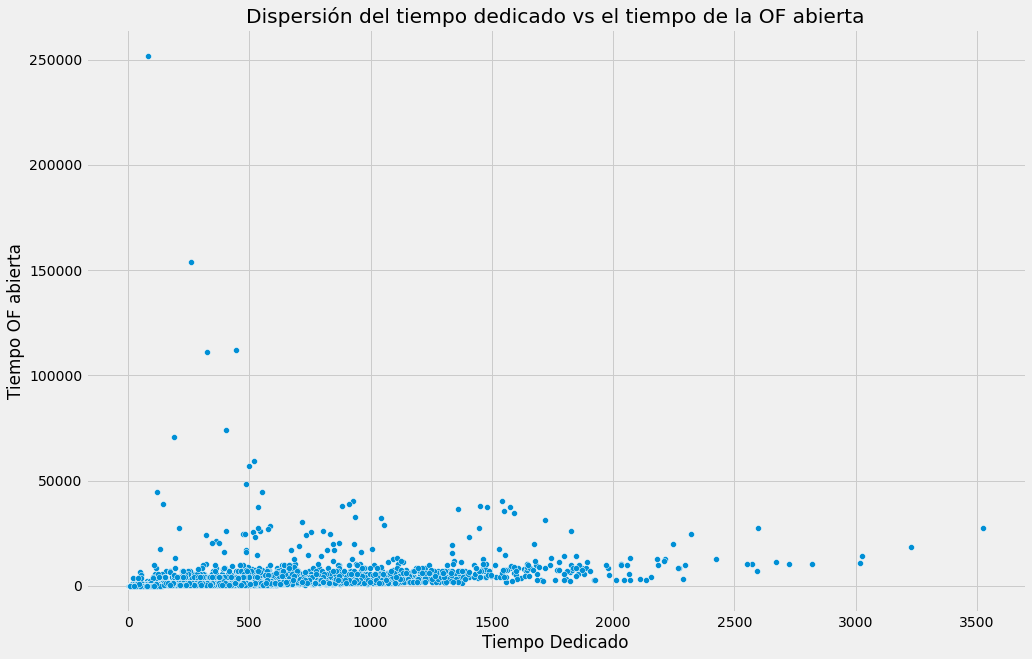

In [166]:
# Mostrar el gráfico en la pantalla:
import matplotlib.pyplot as plt
plt.show()

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 10))

# Crear un gráfico de dispersión utilizando Seaborn:
sns.scatterplot(data=df_of_cleaned_time, x='time_diff_minutes_calculated', y='time_opened_of_minutes')

# Añadir un título y etiquetas de los ejes
ax.set_title("Dispersión del tiempo dedicado vs el tiempo de la OF abierta")
ax.set_xlabel("Tiempo Dedicado")
ax.set_ylabel("Tiempo OF abierta")

# Mostrar el gráfico
plt.show()

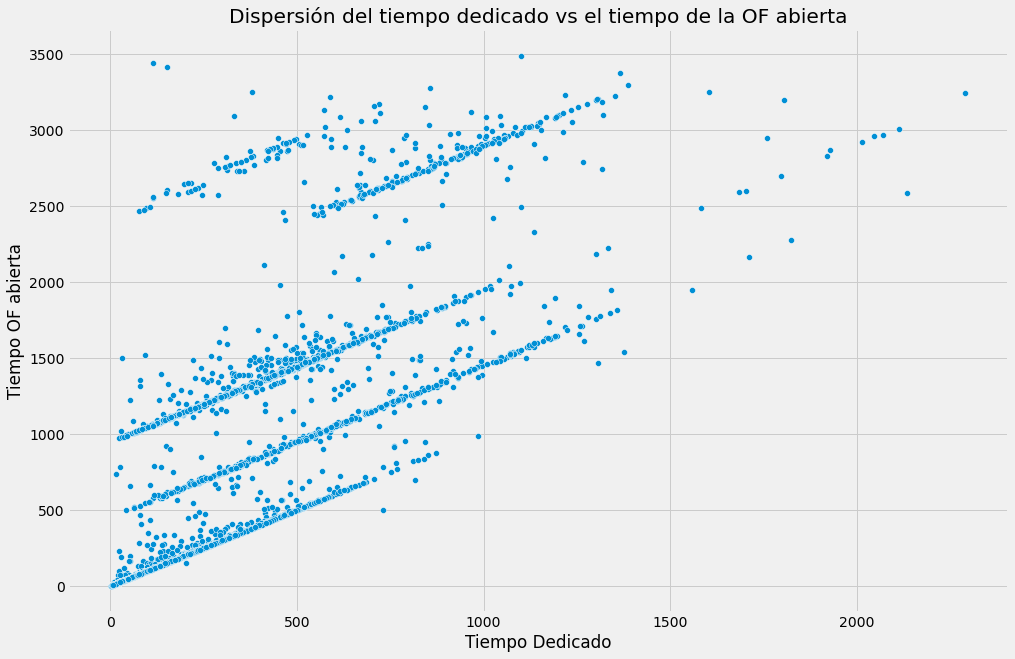

In [167]:
# Mismo grafico anterior pero quitando los Outliers
# Mostrar el gráfico en la pantalla:
import matplotlib.pyplot as plt
plt.show()

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 10))

# Crear un gráfico de dispersión utilizando Seaborn:
sns.scatterplot(data=df_of_cleaned_time[df_of_cleaned_time.time_opened_of_minutes < 3500], x='time_diff_minutes_calculated', y='time_opened_of_minutes')

# Añadir un título y etiquetas de los ejes
ax.set_title("Dispersión del tiempo dedicado vs el tiempo de la OF abierta")
ax.set_xlabel("Tiempo Dedicado")
ax.set_ylabel("Tiempo OF abierta")

# Mostrar el gráfico
plt.show()